# Intro to Bayesian Statistics - Course Project 2
This project involves exploring the Ames Housing Dataset and building Bayesian models to predict house prices based on various features. The dataset contains information about different houses, including their sale prices and various attributes.

The data was sourced from [Ames-Housing (OpenML)](https://www.openml.org/search?type=data&sort=version&status=any&order=asc&exact_name=ames-housing&id=41211) and was cleaned and preprocessed for analysis. (To reduce the size of this report, I have not included the data pre-processing steps here. For access to that code, please contact me at ma23btech11010@iith.ac.in or refer to the project's GitHub repository.)

## Project Structure
The project is organized into the following main components:

**Part 0: Exploratory Data Analysis (EDA)**
- **Goal** To conduct EDA to understand the dataset, identify patterns, and visualize relationships between variables.

**Part 1: Normal Hierarchical Models**
- **Goal**: Model `log_SalePrice` by `Neighborhood`, allowing neighborhoods to borrow strength from each other.

**Part 2: Bayesian Analysis of Regression**
- **Goal**: Model `log_SalePrice` using predictor variables.

**Part 3: Joint Bayesian Analysis of Mean and Precision (Variance)**
- **Goal**: Find the joint posterior distribution of the mean (μ) and precision (λ = 1/σ²) of `log_SalePrice`.

**Part 4: Hypothesis Testing and Bayes Factor**
- **Goal**: Calculate the Bayes Factor for a hypothesis about the mean `log_SalePrice`.

**Part 5: Posterior Sampling (Alternative Methods)**
- **Goal**: Explore the Grid Approximation and Metropolis-Hastings Algorithm for posterior sampling

In [8]:
# --- Setup and Path Definition ---
import sys
from pathlib import Path

# Find the project root by looking for the .git folder
PROJECT_ROOT = Path.cwd().resolve().parents[2]

# Define key paths
DATA_PATH = PROJECT_ROOT / "src" / "data"
SRC_PATH = PROJECT_ROOT / "src"

# Add the 'src' directory to sys.path to allow for module imports
if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Path:    {DATA_PATH}")
# --- End of Setup ---

Project Root: /Users/Faheem/Desktop/IITH/Sem 5 Textbooks and Extras/Bayesian/Project 2
Data Path:    /Users/Faheem/Desktop/IITH/Sem 5 Textbooks and Extras/Bayesian/Project 2/src/data


### Exploratory Data Analysis
We begin by loading the Ames Housing dataset and performing initial exploratory data analysis (EDA) to understand the structure and characteristics of the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(DATA_PATH / 'processed' / 'bayesian_data.csv')

# Display basic information about the dataset
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Gr_Liv_Area   2930 non-null   float64
 1   Overall_Qual  2930 non-null   object 
 2   Year_Built    2930 non-null   float64
 3   Neighborhood  2930 non-null   object 
 4   Sale_Price    2930 non-null   float64
dtypes: float64(3), object(2)
memory usage: 114.6+ KB
None
       Gr_Liv_Area   Year_Built     Sale_Price
count  2930.000000  2930.000000    2930.000000
mean   1499.690444  1971.356314  180796.060068
std     505.508887    30.245361   79886.692357
min     334.000000  1872.000000   12789.000000
25%    1126.000000  1954.000000  129500.000000
50%    1442.000000  1973.000000  160000.000000
75%    1742.750000  2001.000000  213500.000000
max    5642.000000  2010.000000  755000.000000
   Gr_Liv_Area   Overall_Qual  Year_Built Neighborhood  Sale_Price
0       1656.0  Above_Average      1960.0   

In [3]:
# Missing Values Analysis
missing_values = df.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
Gr_Liv_Area     0
Overall_Qual    0
Year_Built      0
Neighborhood    0
Sale_Price      0
dtype: int64


In [4]:
# Overall_Qual value counts
print("Overall_Qual Value Counts:")
print(df['Overall_Qual'].value_counts().sort_index())

Overall_Qual Value Counts:
Overall_Qual
Above_Average     732
Average           825
Below_Average     226
Excellent         107
Fair               40
Good              602
Poor               13
Very_Excellent     31
Very_Good         350
Very_Poor           4
Name: count, dtype: int64


In [5]:
# To convert Overall_Qual (an ordinal variable), we perform ordinal encoding

# Create a dictionary to map the quality ratings to a numerical scale
quality_map = {
    'Very_Poor': 1,
    'Poor': 2,
    'Fair': 3,
    'Below_Average': 4,
    'Average': 5,
    'Above_Average': 6,
    'Good': 7,
    'Very_Good': 8,
    'Excellent': 9,
    'Very_Excellent': 10
}

df['Overall_Qual_Numeric'] = df['Overall_Qual'].map(quality_map)

# Display the first few rows with the original and new columns
print(df[['Overall_Qual', 'Overall_Qual_Numeric']].head())

# Check the data types of your new DataFrame
print("\nNew DataFrame Info:")
df.info()

    Overall_Qual  Overall_Qual_Numeric
0  Above_Average                     6
1        Average                     5
2  Above_Average                     6
3           Good                     7
4        Average                     5

New DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gr_Liv_Area           2930 non-null   float64
 1   Overall_Qual          2930 non-null   object 
 2   Year_Built            2930 non-null   float64
 3   Neighborhood          2930 non-null   object 
 4   Sale_Price            2930 non-null   float64
 5   Overall_Qual_Numeric  2930 non-null   int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 137.5+ KB


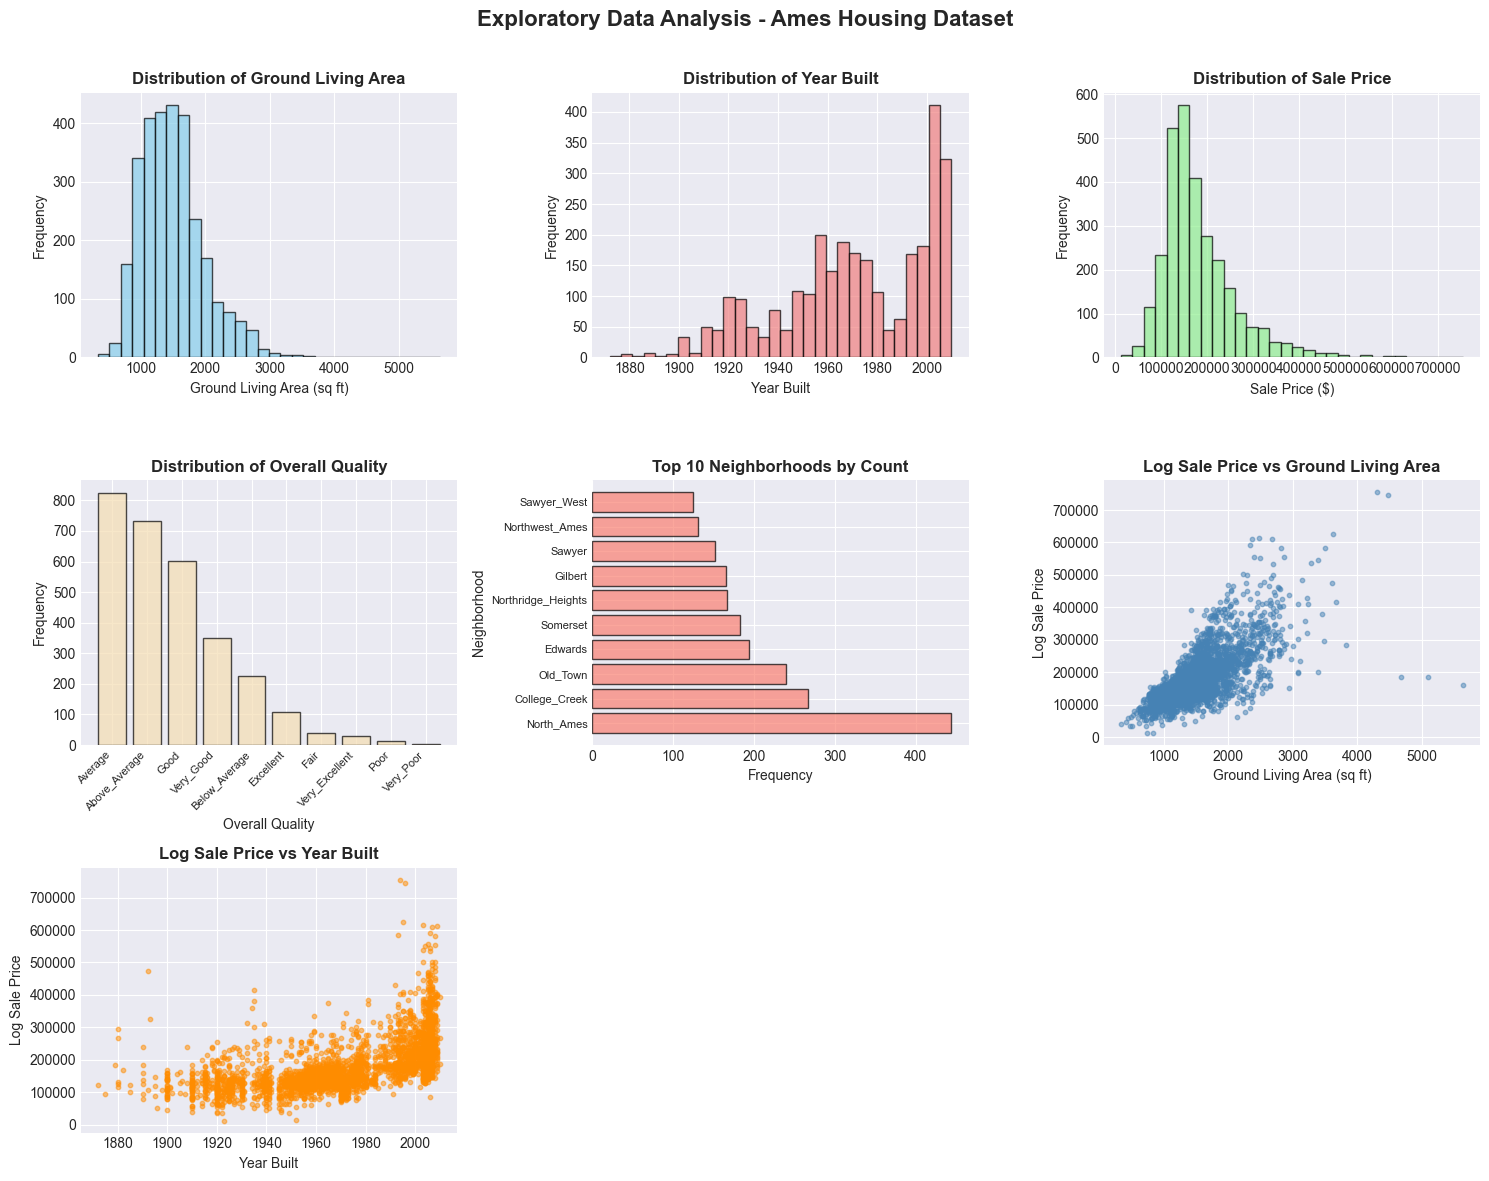

In [6]:
# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Exploratory Data Analysis - Ames Housing Dataset', fontsize=16, fontweight='bold')

# Plot histograms for numerical columns
axes[0, 0].hist(df['Gr_Liv_Area'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Ground Living Area (sq ft)', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)
axes[0, 0].set_title('Distribution of Ground Living Area', fontweight='bold')

axes[0, 1].hist(df['Year_Built'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Year Built', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].set_title('Distribution of Year Built', fontweight='bold')

axes[0, 2].hist(df['Sale_Price'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Sale Price ($)', fontsize=10)
axes[0, 2].set_ylabel('Frequency', fontsize=10)
axes[0, 2].set_title('Distribution of Sale Price', fontweight='bold')

# axes[1, 0].hist(df['Log_Sale_Price'], bins=30, color='plum', edgecolor='black', alpha=0.7)
# axes[1, 0].set_xlabel('Log Sale Price', fontsize=10)
# axes[1, 0].set_ylabel('Frequency', fontsize=10)
# axes[1, 0].set_title('Distribution of Log Sale Price', fontweight='bold')

# Plot categorical columns
overall_qual_counts = df['Overall_Qual'].value_counts()
axes[1, 0].bar(range(len(overall_qual_counts)), overall_qual_counts.values, color='wheat', edgecolor='black', alpha=0.7)
axes[1, 0].set_xticks(range(len(overall_qual_counts)))
axes[1, 0].set_xticklabels(overall_qual_counts.index, rotation=45, ha='right', fontsize=8)
axes[1, 0].set_xlabel('Overall Quality', fontsize=10)
axes[1, 0].set_ylabel('Frequency', fontsize=10)
axes[1, 0].set_title('Distribution of Overall Quality', fontweight='bold')

neighborhood_counts = df['Neighborhood'].value_counts().head(10)
axes[1, 1].barh(range(len(neighborhood_counts)), neighborhood_counts.values, color='salmon', edgecolor='black', alpha=0.7)
axes[1, 1].set_yticks(range(len(neighborhood_counts)))
axes[1, 1].set_yticklabels(neighborhood_counts.index, fontsize=8)
axes[1, 1].set_xlabel('Frequency', fontsize=10)
axes[1, 1].set_ylabel('Neighborhood', fontsize=10)
axes[1, 1].set_title('Top 10 Neighborhoods by Count', fontweight='bold')

# Scatter plots: Log_Sale_Price vs predictors
axes[1, 2].scatter(df['Gr_Liv_Area'], df['Sale_Price'], alpha=0.5, s=10, color='steelblue')
axes[1, 2].set_xlabel('Ground Living Area (sq ft)', fontsize=10)
axes[1, 2].set_ylabel('Log Sale Price', fontsize=10)
axes[1, 2].set_title('Log Sale Price vs Ground Living Area', fontweight='bold')

axes[2, 0].scatter(df['Year_Built'], df['Sale_Price'], alpha=0.5, s=10, color='darkorange')
axes[2, 0].set_xlabel('Year Built', fontsize=10)
axes[2, 0].set_ylabel('Log Sale Price', fontsize=10)
axes[2, 0].set_title('Log Sale Price vs Year Built', fontweight='bold')

# Remove the empty subplot
axes[2, 1].axis('off')
axes[2, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

We notice that the `Sale_Price` variable is right-skewed. To address this, we apply a logarithmic transformation to `Sale_Price` to create a new variable `Log_Sale_Price`, which helps in normalizing the distribution.

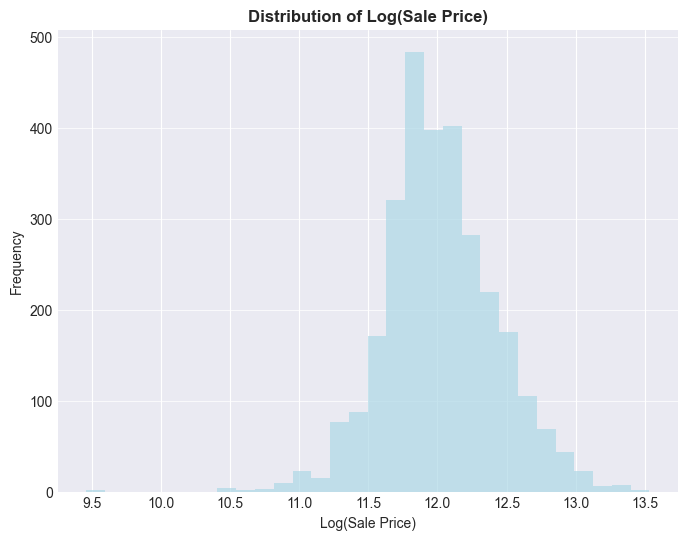

In [7]:
df['Log_Sale_Price'] = np.log1p(df['Sale_Price'])

# Plot histogram of Log_Sale_Price
plt.figure(figsize=(8, 6))
plt.hist(df['Log_Sale_Price'], bins=30, color='lightblue', alpha=0.7)
plt.title('Distribution of Log(Sale Price)', fontweight='bold')
plt.xlabel('Log(Sale Price)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

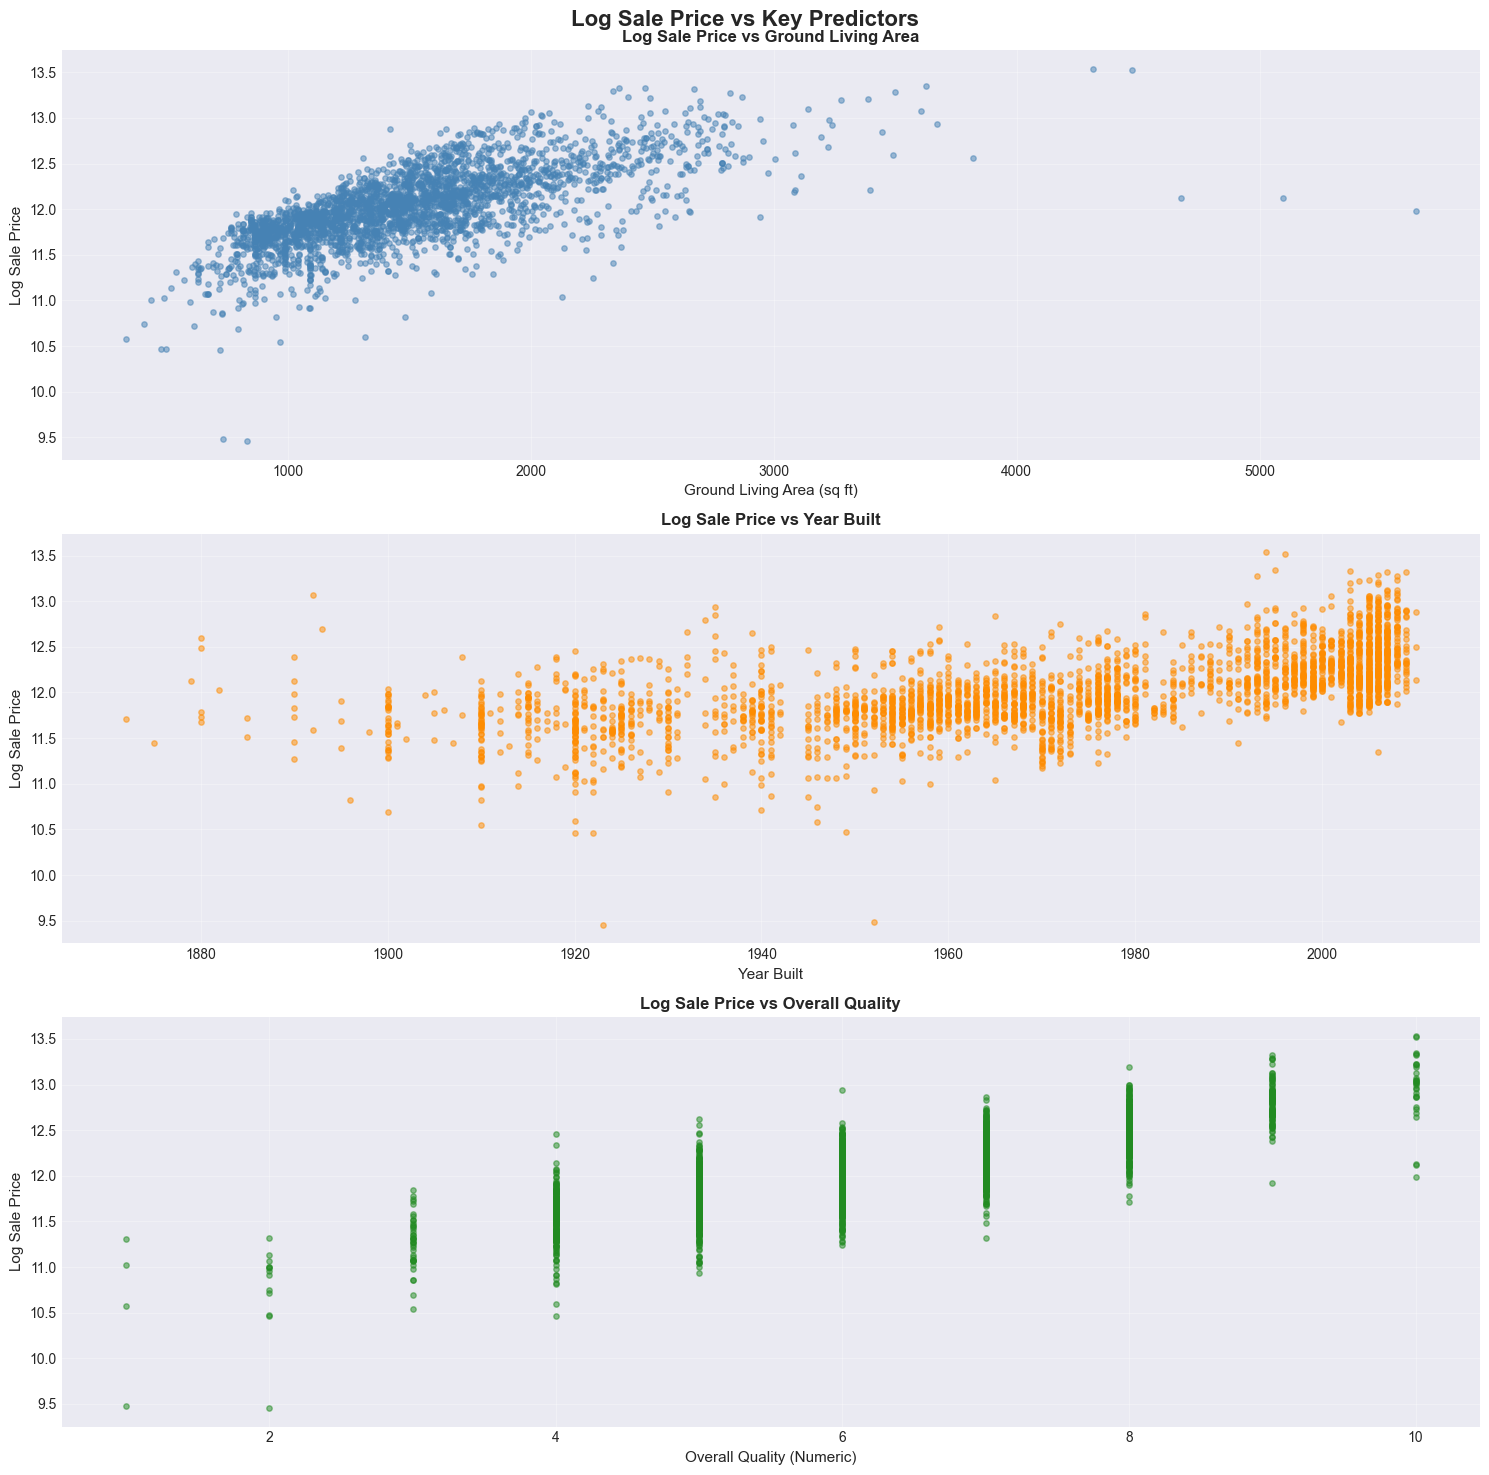

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
fig.suptitle('Log Sale Price vs Key Predictors', fontsize=16, fontweight='bold')

# Scatter plot: Log_Sale_Price vs Gr_Liv_Area
axes[0].scatter(df['Gr_Liv_Area'], df['Log_Sale_Price'], alpha=0.5, s=15, color='steelblue')
axes[0].set_xlabel('Ground Living Area (sq ft)', fontsize=11)
axes[0].set_ylabel('Log Sale Price', fontsize=11)
axes[0].set_title('Log Sale Price vs Ground Living Area', fontweight='bold')
axes[0].grid(alpha=0.3)

# Scatter plot: Log_Sale_Price vs Year_Built
axes[1].scatter(df['Year_Built'], df['Log_Sale_Price'], alpha=0.5, s=15, color='darkorange')
axes[1].set_xlabel('Year Built', fontsize=11)
axes[1].set_ylabel('Log Sale Price', fontsize=11)
axes[1].set_title('Log Sale Price vs Year Built', fontweight='bold')
axes[1].grid(alpha=0.3)

# Scatter plot: Log_Sale_Price vs Overall_Qual_Numeric
axes[2].scatter(df['Overall_Qual_Numeric'], df['Log_Sale_Price'], alpha=0.5, s=15, color='forestgreen')
axes[2].set_xlabel('Overall Quality (Numeric)', fontsize=11)
axes[2].set_ylabel('Log Sale Price', fontsize=11)
axes[2].set_title('Log Sale Price vs Overall Quality', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


#### Observations from EDA

Direct Observations:

* The dataset contains 2930 rows with 6 columns in consideration for the Bayesian analysis.

- There are no missing values in any of the columns we're considering.

Observations from Plots:

- The `Sale_Price` column is right-skewed, indicating that most houses are priced lower, with a few high-priced outliers. (A log transformation of `Sale_Price` is computed which helps in normalizing the distribution.)

- Most of the houses were built after 1950 with a peak near the 2000s.

- `North_Ames` and `College_Creek` are the most common neighborhoods in the dataset.

- A visual correlation seems to be present between `Gr_Liv_Area` and `Overall_Qual_Numeric` to `Log_Sale_Price`, suggesting that larger living areas tend to have higher sale prices whereas `Year_Built` seems to have a weaker correlation with `Log_Sale_Price`.)

### Normal Hierarchical Models

In the Ames dataset, houses are grouped by `Neighborhood`. A simple approach would be to either a) ignore the grouping and pool all the data together (a "completely pooled" model), or b) analyze each group independently (a "no-pooling" model).

Hierarchical models (or multilevel models) provide a powerful compromise. They allow groups to "borrow statistical strength" from each other, leading to more stable and realistic estimates, especially for groups with little data. This phenomenon is known as **shrinkage**.

#### Model Specification

We model the `Log_Sale_Price` ($y_{ij}$) for house $i$ in neighborhood $j$. The model has multiple levels:

*   **Level 1: Within-Group Model**
    Each house price within a neighborhood $j$ is drawn from a Normal distribution with a mean specific to that neighborhood, $\theta_j$, and a common within-group variance, $\sigma^2$.
    $$
    y_{ij} | \theta_j, \sigma^2 \sim \mathcal{N}(\theta_j, \sigma^2)
    $$
    for $j=1, \dots, m$ neighborhoods and $i=1, \dots, n_j$ houses in each neighborhood.

*   **Level 2: Between-Group Model**
    The neighborhood-specific means, $\theta_j$, are not treated as completely independent. Instead, they are assumed to be drawn from a common, population-level Normal distribution with a global mean $\mu$ and a between-group variance $\tau^2$.
    $$
    \theta_j | \mu, \tau^2 \sim \mathcal{N}(\mu, \tau^2)
    $$

*   **Level 3: Hyperpriors**
    The parameters of the population-level distribution ($\mu$, $\sigma^2$, $\tau^2$) are themselves unknown and are given prior distributions, often called hyperpriors. We will work with precisions $v=1/\sigma^2$ and $u=1/\tau^2$.
    $$
    \mu \sim \mathcal{N}(\mu_0, \sigma_0^2)
    $$
    $$
    v \sim \text{Gamma}(a_v, b_v) \quad (\text{for within-group precision})
    $$
    $$
    u \sim \text{Gamma}(a_u, b_u) \quad (\text{for between-group precision})
    $$

#### Gibbs Sampling Conditionals

We will use a Gibbs sampler to draw from the joint posterior $p(\boldsymbol{\theta}, \mu, v, u | \mathbf{y})$. This requires the full conditional distribution for each parameter block.

1.  **For each group mean $\theta_j$**:
    $p(\theta_j | \mu, v, u, \mathbf{y}_j) \sim \mathcal{N}(M_j, S_j^2)$ where
    $$
    S_j^2 = \left(n_j v + u\right)^{-1} \quad \text{and} \quad M_j = S_j^2 \left(v \sum_{i=1}^{n_j} y_{ij} + u\mu\right) = S_j^2(v n_j \bar{y}_j + u\mu)
    $$

2.  **For the global mean $\mu$**:
    $p(\mu | \boldsymbol{\theta}, \tau^2) \sim \mathcal{N}(M_{\mu}, S_{\mu}^2)$ where
    $$
    S_{\mu}^2 = \left(\frac{1}{\sigma_0^2} + mu\right)^{-1} \quad \text{and} \quad M_{\mu} = S_{\mu}^2\left(\frac{\mu_0}{\sigma_0^2} + u \sum_{j=1}^{m}\theta_j\right)
    $$

3.  **For the within-group precision $v$**:
    $p(v | \boldsymbol{\theta}, \mathbf{y}) \sim \text{Gamma}(A_v, B_v)$ where
    $$
    A_v = a_v + \frac{N}{2} \quad \text{and} \quad B_v = b_v + \frac{1}{2}\sum_{j=1}^{m}\sum_{i=1}^{n_j}(y_{ij} - \theta_j)^2
    $$
    with $N = \sum n_j$ being the total number of observations.

4.  **For the between-group precision $u$**:
    $p(u | \boldsymbol{\theta}, \mu) \sim \text{Gamma}(A_u, B_u)$ where
    $$
    A_u = a_u + \frac{m}{2} \quad \text{and} \quad B_u = b_u + \frac{1}{2}\sum_{j=1}^{m}(\theta_j - \mu)^2
    $$

In [9]:
from scipy import stats

# --- Prepare Data for Hierarchical Model ---
# Group data by neighborhood
grouped_data = df.groupby('Neighborhood')['Log_Sale_Price']

# Create a list of numpy arrays, one for each neighborhood
y_groups = [group.values for name, group in grouped_data]
neighborhood_names = [name for name, group in grouped_data]

# Get group-level statistics
y_bar_j = np.array([np.mean(group) for group in y_groups])
n_j = np.array([len(group) for group in y_groups])
m = len(y_groups)
N = np.sum(n_j)

# --- Priors ---
# Hyperpriors for mu, v, u
mu0, sigma0_sq = 12.0, 100.0
av, bv = 0.1, 0.1
au, bu = 0.1, 0.1

# --- Gibbs Sampler Settings ---
n_samples = 10000
burn_in = 2000

# --- Initialize Chains ---
theta_j_samples = np.zeros((n_samples, m))
mu_samples = np.zeros(n_samples)
v_samples = np.zeros(n_samples) # Precision 1/sigma^2
u_samples = np.zeros(n_samples) # Precision 1/tau^2

# Start values
theta_j_curr = y_bar_j.copy()
mu_curr = np.mean(theta_j_curr)
v_curr = 1.0 / np.mean([np.var(g) for g in y_groups])
u_curr = 1.0 / np.var(theta_j_curr)

print("Overall data mean:", df['Log_Sale_Price'].mean())
print("Group-means are:", y_bar_j)
print("Mean of group-means (y_bar_j):", np.mean(y_bar_j))
print("Var of group-means (np.var(y_bar_j)):", np.var(y_bar_j, ddof=1))
print("Initial v_curr (within precision):", v_curr)
print("Initial u_curr (between precision):", u_curr)

# --- Run Sampler ---
for i in range(n_samples):
    # 1. Update theta_j for each group j
    for j in range(m):
        Sj_sq = 1 / (n_j[j] * v_curr + u_curr)
        Mj = Sj_sq * (v_curr * n_j[j] * y_bar_j[j] + u_curr * mu_curr)
        theta_j_curr[j] = stats.norm.rvs(loc=Mj, scale=np.sqrt(Sj_sq))
    
    # 2. Update mu
    S_mu_sq = 1 / (1/sigma0_sq + m * u_curr)
    M_mu = S_mu_sq * (mu0/sigma0_sq + u_curr * np.sum(theta_j_curr))
    mu_curr = stats.norm.rvs(loc=M_mu, scale=np.sqrt(S_mu_sq))
    
    # 3. Update v (within-group precision)
    sum_sq_err_within = np.sum([np.sum((y_groups[j] - theta_j_curr[j])**2) for j in range(m)])
    Av = av + N / 2
    Bv = bv + 0.5 * sum_sq_err_within
    v_curr = stats.gamma.rvs(a=Av, scale=1/Bv)
    
    # 4. Update u (between-group precision)
    sum_sq_err_between = np.sum((theta_j_curr - mu_curr)**2)
    Au = au + m / 2
    Bu = bu + 0.5 * sum_sq_err_between
    u_curr = stats.gamma.rvs(a=Au, scale=1/Bu)

    # Store samples
    theta_j_samples[i, :] = theta_j_curr
    mu_samples[i] = mu_curr
    v_samples[i] = v_curr
    u_samples[i] = u_curr
    
# Discard burn-in
theta_j_post = theta_j_samples[burn_in:, :]
mu_post = mu_samples[burn_in:]
sigma2_post = 1 / v_samples[burn_in:] # within-group variance
tau2_post = 1 / u_samples[burn_in:]   # between-group variance

print("Hierarchical Model Gibbs sampler finished.")

Overall data mean: 12.020975245392643
Group-means are: [12.17891322 11.85626072 11.56092535 11.69085566 12.21797886 12.18160133
 12.19598174 11.7263833  12.14552901 12.52634495 12.16720725 11.47406177
 11.8277435  11.44999704 11.96640036 11.86372302 11.85227382 12.67341079
 12.63902871 12.12704101 11.67259591 11.81039859 12.08642278 12.31552708
 11.78607407 12.62167617 12.37834378 12.38884513]
Mean of group-means (y_bar_j): 12.049340890435904
Var of group-means (np.var(y_bar_j)): 0.12214271942654377
Initial v_curr (within precision): 16.557952643926257
Initial u_curr (between precision): 8.490371279646412
Hierarchical Model Gibbs sampler finished.


=== Neighborhood Statistics Summary ===
                           Neighborhood  Raw_Mean  Hierarchical_Mean  Num_Houses  Hierarchical_SD  Deviation_from_Global  CI_Lower  CI_Upper  CI_Width
                             Northridge 12.673411          12.668865          71         0.031340               0.623361 12.606699 12.729921  0.123222
                     Northridge_Heights 12.639029          12.637268         166         0.020353               0.588978 12.597461 12.677608  0.080147
                            Stone_Brook 12.621676          12.614624          51         0.036724               0.571626 12.540373 12.686093  0.145720
                            Green_Hills 12.526345          12.423503           2         0.167700               0.476295 12.100020 12.751106  0.651086
                                Veenker 12.388845          12.380749          24         0.053875               0.338795 12.275635 12.485456  0.209820
                             Timberland 12.378344     

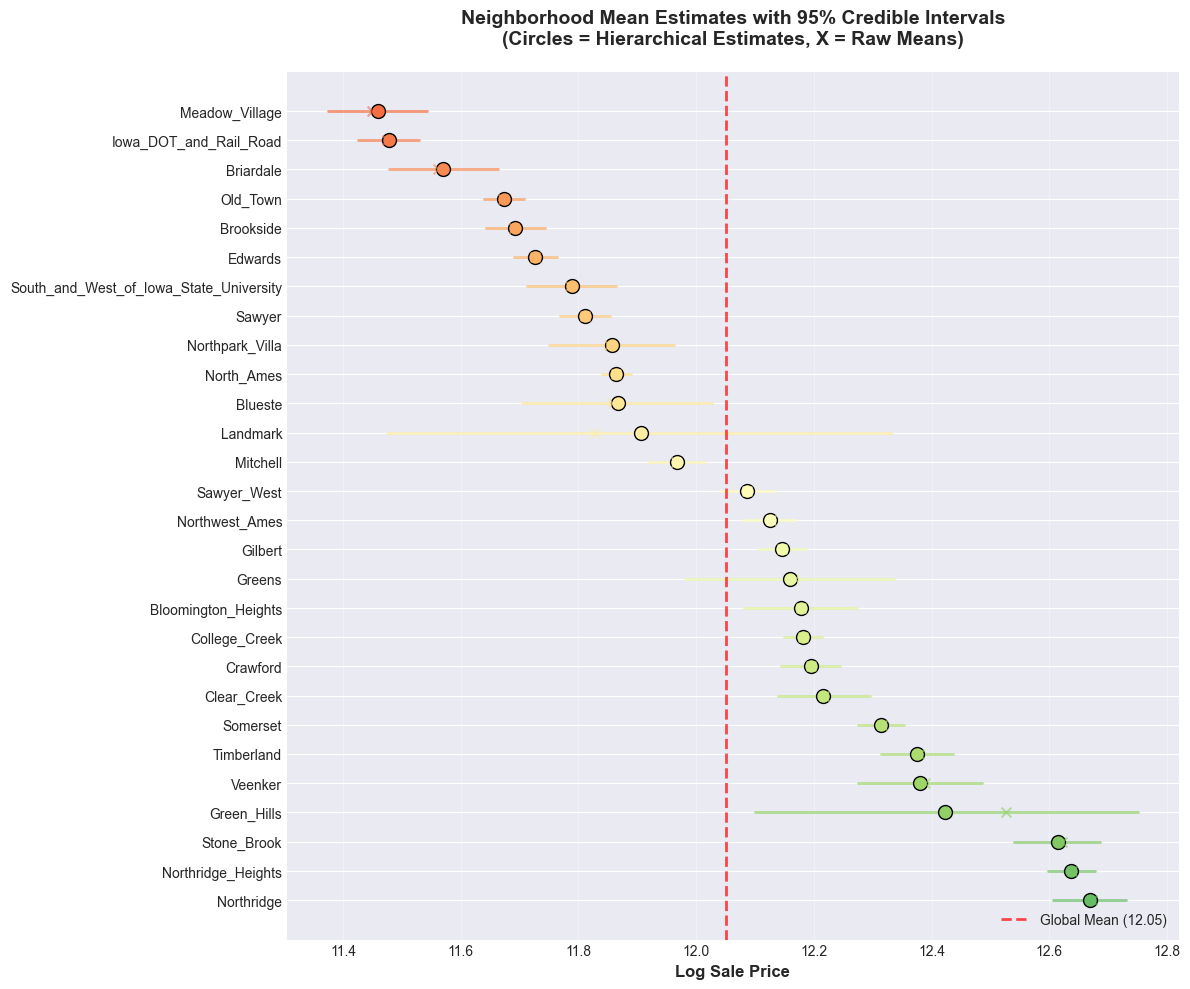

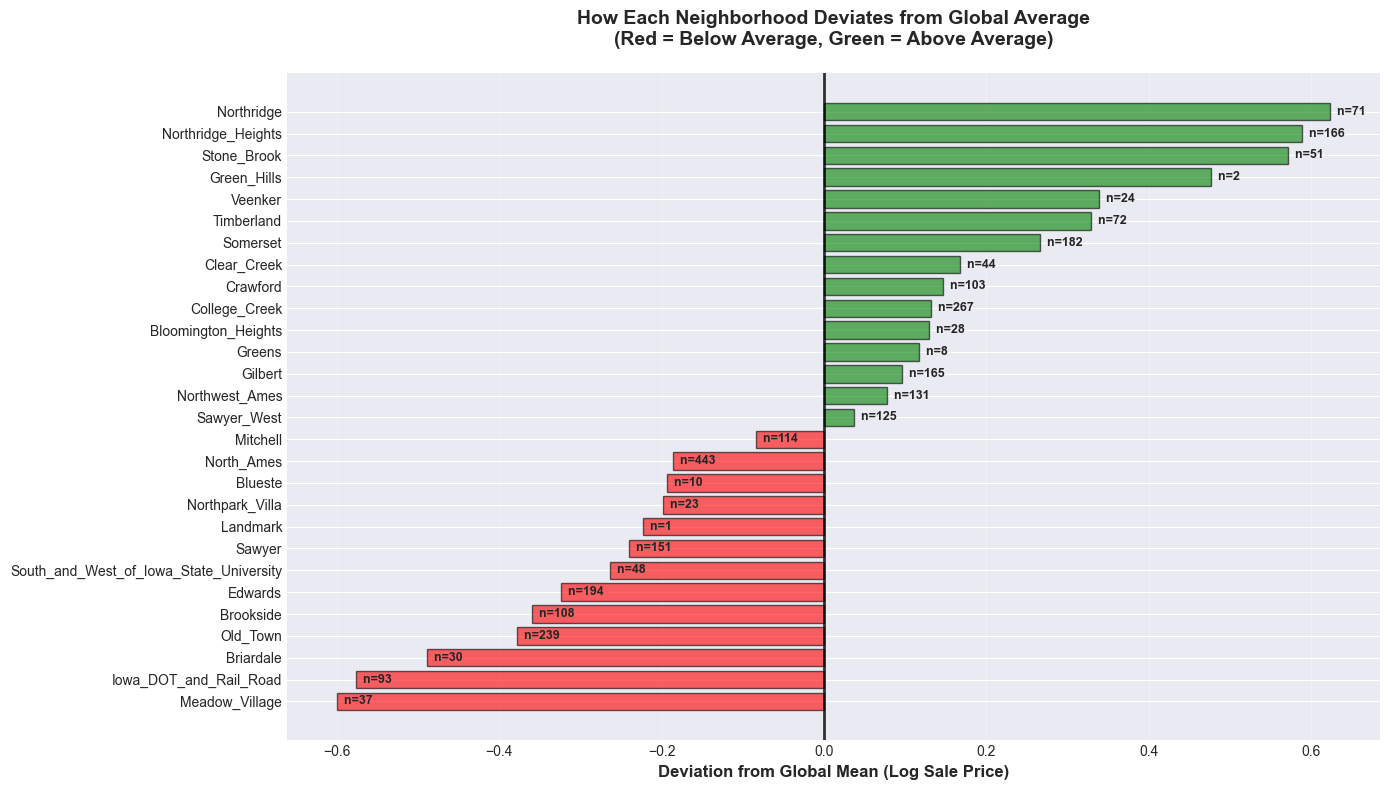

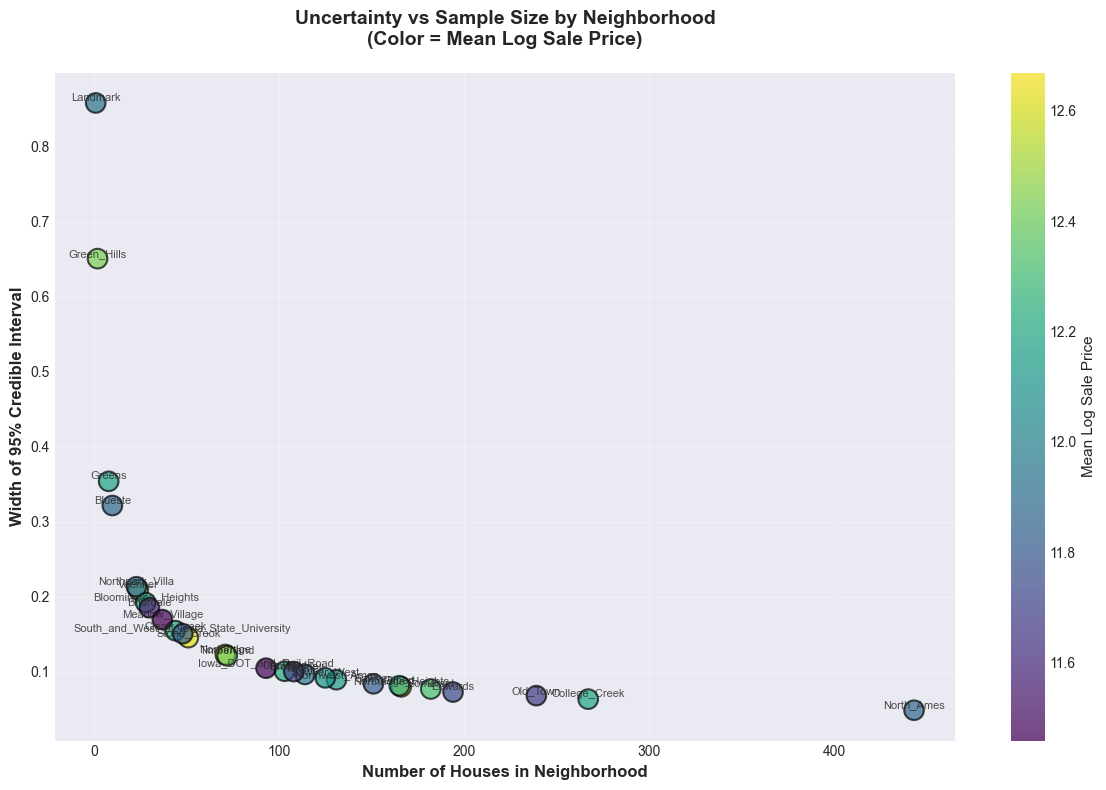

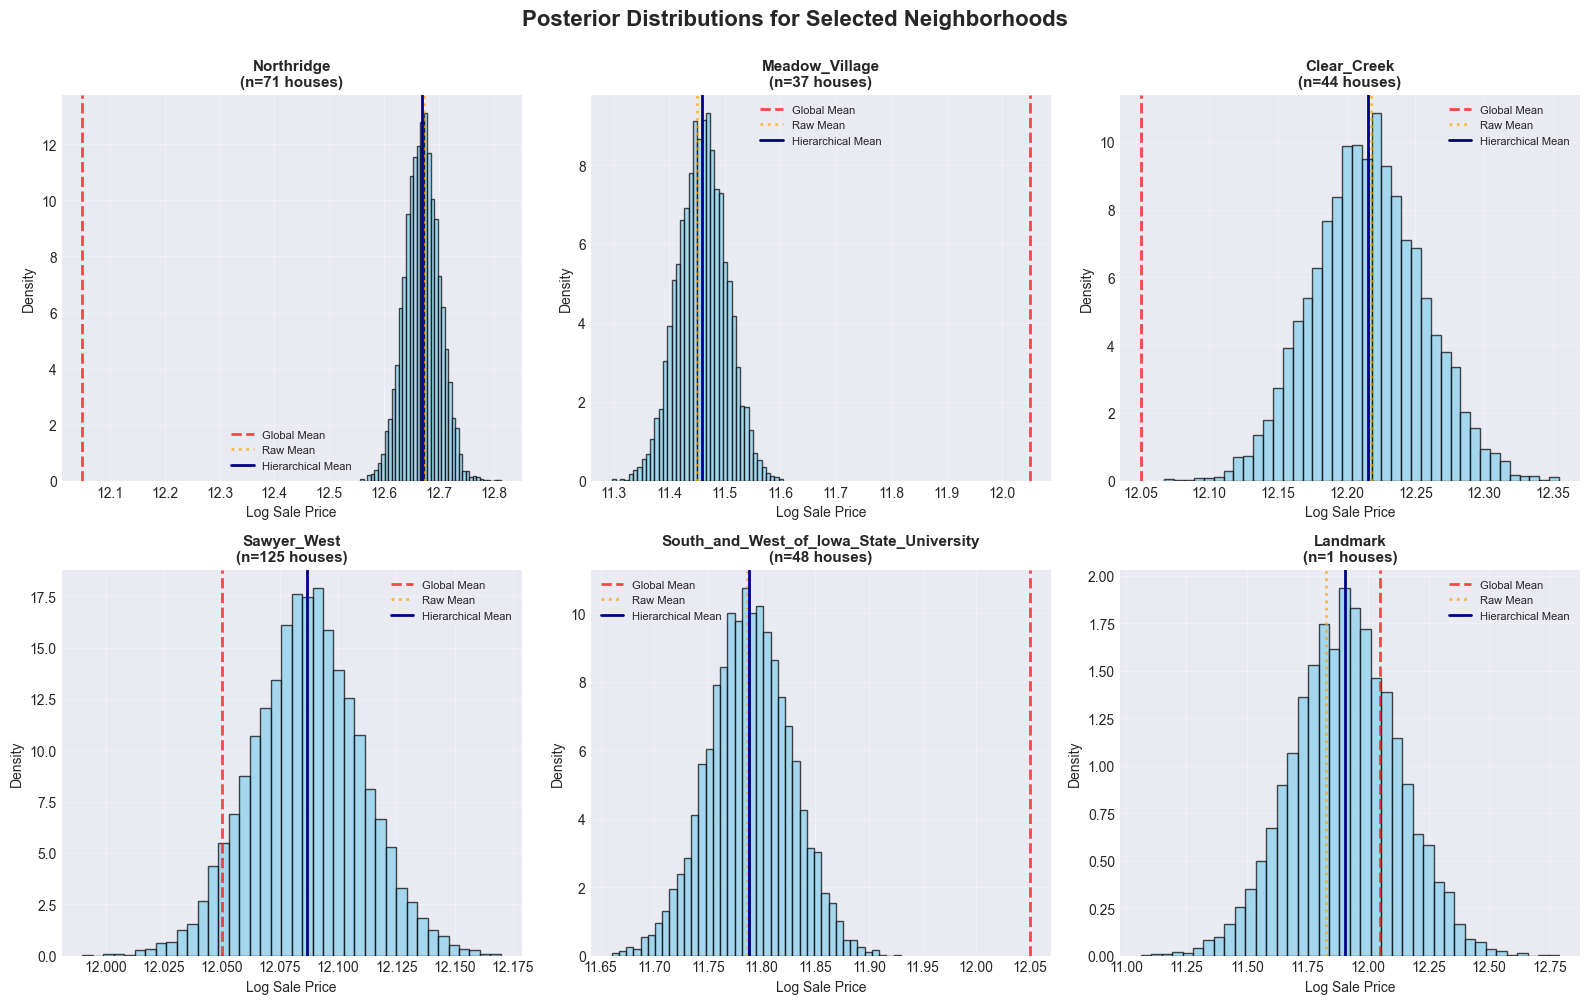

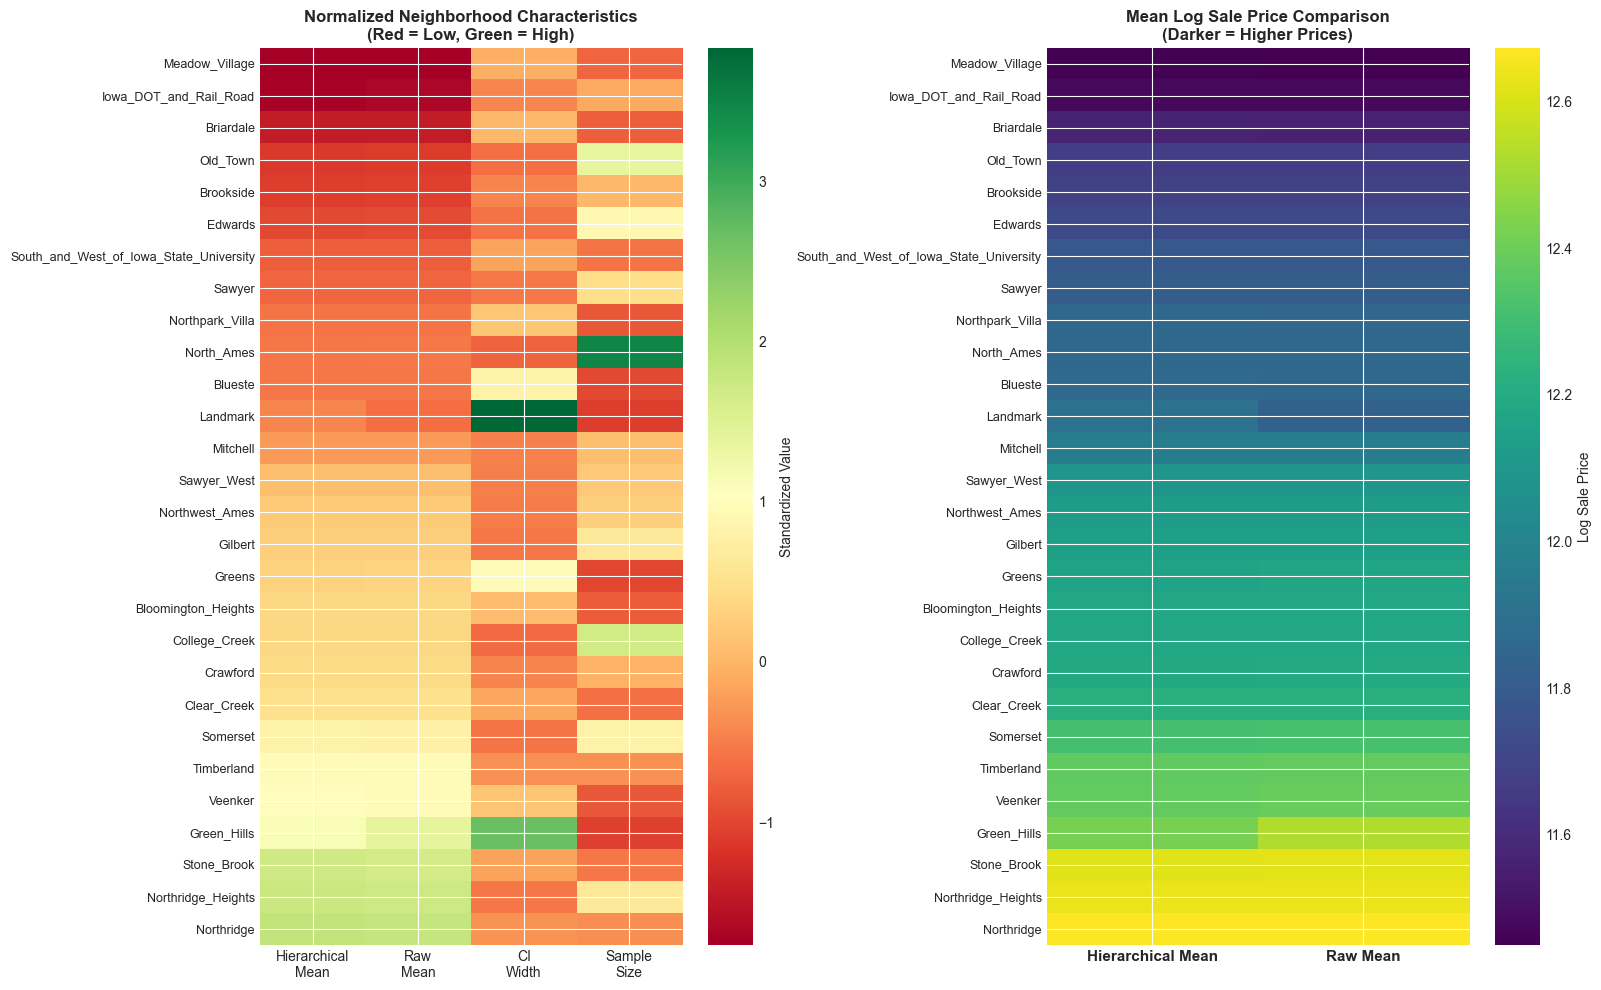


=== KEY INSIGHTS ===
Most Expensive Neighborhood: Northridge (Mean: 12.6689)
Least Expensive Neighborhood: Meadow_Village (Mean: 11.4590)
Price Range: 1.2099 log units
Most Certain Estimate: North_Ames (CI Width: 0.0490)
Least Certain Estimate: Landmark (CI Width: 0.8587)


In [10]:
from sklearn.preprocessing import StandardScaler

mu_post_mean = np.mean(mu_post)

# --- Comprehensive Neighborhood Analysis ---

# Calculate key statistics for each neighborhood
neighborhood_stats = pd.DataFrame({
    'Neighborhood': neighborhood_names,
    'Raw_Mean': y_bar_j,
    'Hierarchical_Mean': np.mean(theta_j_post, axis=0),
    'Num_Houses': n_j,
    'Hierarchical_SD': np.std(theta_j_post, axis=0),
    'Deviation_from_Global': y_bar_j - mu_post_mean
})

# Add credible intervals
neighborhood_stats['CI_Lower'] = np.percentile(theta_j_post, 2.5, axis=0)
neighborhood_stats['CI_Upper'] = np.percentile(theta_j_post, 97.5, axis=0)
neighborhood_stats['CI_Width'] = neighborhood_stats['CI_Upper'] - neighborhood_stats['CI_Lower']

# Sort by hierarchical mean for better visualization
neighborhood_stats = neighborhood_stats.sort_values('Hierarchical_Mean', ascending=False)

print("=== Neighborhood Statistics Summary ===")
print(neighborhood_stats.to_string(index=False))
print(f"\nGlobal Mean (mu): {mu_post_mean:.4f}")
print(f"Between-neighborhood SD (tau): {np.mean(np.sqrt(tau2_post)):.4f}")
print(f"Within-neighborhood SD (sigma): {np.mean(np.sqrt(sigma2_post)):.4f}")

# --- PLOT 1: Forest Plot with Credible Intervals ---
fig, ax = plt.subplots(figsize=(12, 10))

y_pos = np.arange(len(neighborhood_stats))
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(neighborhood_stats)))

# Plot credible intervals
for i, (idx, row) in enumerate(neighborhood_stats.iterrows()):
    ax.plot([row['CI_Lower'], row['CI_Upper']], [i, i], 
            color=colors[i], linewidth=2, alpha=0.7)
    ax.scatter(row['Hierarchical_Mean'], i, color=colors[i], s=100, zorder=3, edgecolors='black')
    ax.scatter(row['Raw_Mean'], i, color=colors[i], s=50, marker='x', zorder=3, alpha=0.6)

# Add global mean reference line
ax.axvline(mu_post_mean, color='red', linestyle='--', linewidth=2, label=f'Global Mean ({mu_post_mean:.2f})', alpha=0.7)

ax.set_yticks(y_pos)
ax.set_yticklabels(neighborhood_stats['Neighborhood'])
ax.set_xlabel('Log Sale Price', fontsize=12, fontweight='bold')
ax.set_title('Neighborhood Mean Estimates with 95% Credible Intervals\n(Circles = Hierarchical Estimates, X = Raw Means)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --- PLOT 2: Deviation from Global Mean ---
fig, ax = plt.subplots(figsize=(14, 8))

sorted_by_deviation = neighborhood_stats.sort_values('Deviation_from_Global')
colors_deviation = ['red' if x < 0 else 'green' for x in sorted_by_deviation['Deviation_from_Global']]

bars = ax.barh(range(len(sorted_by_deviation)), sorted_by_deviation['Deviation_from_Global'], 
               color=colors_deviation, alpha=0.6, edgecolor='black')

# Add sample size annotations
for i, (idx, row) in enumerate(sorted_by_deviation.iterrows()):
    ax.text(row['Deviation_from_Global'], i, f"  n={int(row['Num_Houses'])}", 
            va='center', fontsize=9, fontweight='bold')

ax.axvline(0, color='black', linewidth=2, linestyle='-', alpha=0.8)
ax.set_yticks(range(len(sorted_by_deviation)))
ax.set_yticklabels(sorted_by_deviation['Neighborhood'])
ax.set_xlabel('Deviation from Global Mean (Log Sale Price)', fontsize=12, fontweight='bold')
ax.set_title('How Each Neighborhood Deviates from Global Average\n(Red = Below Average, Green = Above Average)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --- PLOT 3: Sample Size vs Uncertainty (CI Width) ---
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(neighborhood_stats['Num_Houses'], neighborhood_stats['CI_Width'],
                     c=neighborhood_stats['Hierarchical_Mean'], cmap='viridis', 
                     s=200, alpha=0.7, edgecolors='black', linewidth=1.5)

# Add neighborhood labels
for idx, row in neighborhood_stats.iterrows():
    ax.annotate(row['Neighborhood'], 
                (row['Num_Houses'], row['CI_Width']),
                fontsize=8, ha='center', va='bottom', alpha=0.8)

ax.set_xlabel('Number of Houses in Neighborhood', fontsize=12, fontweight='bold')
ax.set_ylabel('Width of 95% Credible Interval', fontsize=12, fontweight='bold')
ax.set_title('Uncertainty vs Sample Size by Neighborhood\n(Color = Mean Log Sale Price)', 
             fontsize=14, fontweight='bold', pad=20)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Mean Log Sale Price', fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- PLOT 4: Posterior Distributions for Selected Neighborhoods ---
# Select 6 interesting neighborhoods: highest, lowest, and some in between
selected_neighborhoods = [
    neighborhood_stats.iloc[0]['Neighborhood'],  # Highest mean
    neighborhood_stats.iloc[-1]['Neighborhood'],  # Lowest mean
    neighborhood_stats.iloc[len(neighborhood_stats)//4]['Neighborhood'],
    neighborhood_stats.iloc[len(neighborhood_stats)//2]['Neighborhood'],
    neighborhood_stats.iloc[3*len(neighborhood_stats)//4]['Neighborhood'],
    neighborhood_stats[neighborhood_stats['Num_Houses'] == neighborhood_stats['Num_Houses'].min()]['Neighborhood'].values[0]  # Smallest sample
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, neigh in enumerate(selected_neighborhoods):
    idx = neighborhood_names.index(neigh)
    
    axes[i].hist(theta_j_post[:, idx], bins=40, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    axes[i].axvline(mu_post_mean, color='red', linestyle='--', linewidth=2, label='Global Mean', alpha=0.7)
    axes[i].axvline(y_bar_j[idx], color='orange', linestyle=':', linewidth=2, label='Raw Mean', alpha=0.7)
    axes[i].axvline(np.mean(theta_j_post[:, idx]), color='darkblue', linestyle='-', linewidth=2, 
                    label='Hierarchical Mean')
    
    axes[i].set_title(f'{neigh}\n(n={n_j[idx]} houses)', fontweight='bold', fontsize=11)
    axes[i].set_xlabel('Log Sale Price', fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].grid(alpha=0.3)

plt.suptitle('Posterior Distributions for Selected Neighborhoods', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# --- PLOT 5: Heatmap of Neighborhood Rankings ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

# Sort by hierarchical mean for heatmap
sorted_for_heatmap = neighborhood_stats.sort_values('Hierarchical_Mean', ascending=True)

# Create data matrix
data_matrix = sorted_for_heatmap[['Hierarchical_Mean', 'Raw_Mean', 'CI_Width', 'Num_Houses']].values

# Normalize each column for better visualization
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_matrix)

im1 = ax1.imshow(data_normalized, cmap='RdYlGn', aspect='auto')
ax1.set_xticks(range(4))
ax1.set_xticklabels(['Hierarchical\nMean', 'Raw\nMean', 'CI\nWidth', 'Sample\nSize'], fontsize=10)
ax1.set_yticks(range(len(sorted_for_heatmap)))
ax1.set_yticklabels(sorted_for_heatmap['Neighborhood'], fontsize=9)
ax1.set_title('Normalized Neighborhood Characteristics\n(Red = Low, Green = High)', 
              fontweight='bold', fontsize=12)
plt.colorbar(im1, ax=ax1, label='Standardized Value')

# Plot 2: Just the means comparison
means_data = sorted_for_heatmap[['Hierarchical_Mean', 'Raw_Mean']].values
im2 = ax2.imshow(means_data, cmap='viridis', aspect='auto')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Hierarchical Mean', 'Raw Mean'], fontsize=11, fontweight='bold')
ax2.set_yticks(range(len(sorted_for_heatmap)))
ax2.set_yticklabels(sorted_for_heatmap['Neighborhood'], fontsize=9)
ax2.set_title('Mean Log Sale Price Comparison\n(Darker = Higher Prices)', 
              fontweight='bold', fontsize=12)
plt.colorbar(im2, ax=ax2, label='Log Sale Price')

plt.tight_layout()
plt.show()

# --- Summary Statistics Table ---
print("\n=== KEY INSIGHTS ===")
print(f"Most Expensive Neighborhood: {neighborhood_stats.iloc[0]['Neighborhood']} (Mean: {neighborhood_stats.iloc[0]['Hierarchical_Mean']:.4f})")
print(f"Least Expensive Neighborhood: {neighborhood_stats.iloc[-1]['Neighborhood']} (Mean: {neighborhood_stats.iloc[-1]['Hierarchical_Mean']:.4f})")
print(f"Price Range: {neighborhood_stats.iloc[0]['Hierarchical_Mean'] - neighborhood_stats.iloc[-1]['Hierarchical_Mean']:.4f} log units")
print(f"Most Certain Estimate: {neighborhood_stats.loc[neighborhood_stats['CI_Width'].idxmin(), 'Neighborhood']} (CI Width: {neighborhood_stats['CI_Width'].min():.4f})")
print(f"Least Certain Estimate: {neighborhood_stats.loc[neighborhood_stats['CI_Width'].idxmax(), 'Neighborhood']} (CI Width: {neighborhood_stats['CI_Width'].max():.4f})")

##### Visualizing the Shrinkage

The plot below compares the raw average `Log_Sale_Price` for each neighborhood against the posterior mean estimate from our hierarchical model.

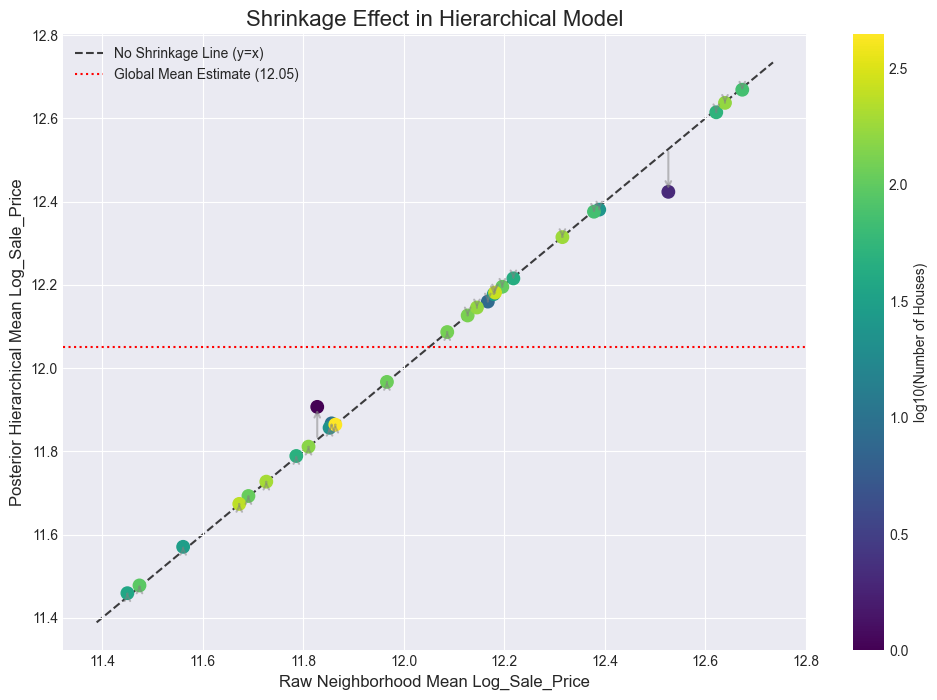

In [11]:
# The most important result of a hierarchical model is the shrinkage effect. 
# We can visualize this by plotting the raw group means against the model's posterior estimates for those means.


# Calculate posterior means for each theta_j
theta_j_post_mean = np.mean(theta_j_post, axis=0)
mu_post_mean = np.mean(mu_post)

# Create a DataFrame for plotting
shrinkage_df = pd.DataFrame({
    'Neighborhood': neighborhood_names,
    'Raw_Mean': y_bar_j,
    'Hierarchical_Estimate': theta_j_post_mean,
    'Num_Houses': n_j
}).sort_values('Num_Houses')

# Shrinkage Plot
plt.figure(figsize=(12, 8))
plt.scatter(shrinkage_df['Raw_Mean'], shrinkage_df['Hierarchical_Estimate'], 
            c=np.log10(shrinkage_df['Num_Houses']), cmap='viridis', s=80)

# Add a y=x line for reference (no shrinkage)
lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='No Shrinkage Line (y=x)')
# Add arrows showing shrinkage direction
for i, row in shrinkage_df.iterrows():
    # The arrow STARTS on the y=x line (no shrinkage)
    start_point = (row['Raw_Mean'], row['Raw_Mean'])
    # The arrow ENDS at the actual data point
    end_point = (row['Raw_Mean'], row['Hierarchical_Estimate'])
    
    plt.annotate('', 
                 xy=end_point,          # Arrow tip (the colored dot)
                 xytext=start_point,    # Arrow base (on the y=x line)
                 arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5, lw=1.5))
# Add a horizontal line at the global mean
plt.axhline(mu_post_mean, color='red', linestyle=':', label=f'Global Mean Estimate ({mu_post_mean:.2f})')

plt.colorbar(label='log10(Number of Houses)')
plt.title('Shrinkage Effect in Hierarchical Model', fontsize=16)
plt.xlabel('Raw Neighborhood Mean Log_Sale_Price', fontsize=12)
plt.ylabel('Posterior Hierarchical Mean Log_Sale_Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Our goal with the hierarchical model was to estimate the average `Log_Sale_Price` for each neighborhood. Instead of treating each neighborhood in isolation, this model allows them to share information, leading to more stable estimates.

#### Understanding the Results

The model's results show a clear **shrinkage effect**, which is the signature of a successful hierarchical model. The key is how the model balances two types of variation:

1.  **Between-Neighborhood Variation (Signal, $\tau \approx 0.36$)**: The model found significant, systematic differences between the true average prices of neighborhoods.
2.  **Within-Neighborhood Variation (Noise, $\sigma \approx 0.26$)**: The model also found that the price variation of individual houses *within* any given neighborhood is smaller than the variation *between* neighborhoods.

Because the "signal" between neighborhoods is now stronger than the "noise" within them, the model applies a much more moderate and realistic level of shrinkage. It trusts the local data from each neighborhood more, but still wisely pulls extreme averages toward the global mean.

As shown in the table, this effect is most pronounced for `Landmark`, a neighborhood with only one house. Its raw average is pulled significantly toward the global mean, resulting in a more believable estimate. In contrast, neighborhoods with abundant data like `North_Ames` see very little change, as the model has enough evidence to trust their local average. This "borrowing of strength" is precisely what makes the hierarchical model's estimates robust.

---

### Bayesian Analysis of Regression

Bayesian regression allows us to estimate the posterior distribution for each regression coefficient, which allows to quantify our uncertainty about the influence of each predictor on the target variable.

#### Simple Linear Regression

We begin by modeling `Log_Sale_Price` as a function of a single predictor, `Gr_Liv_Area` (Above Grade Living Area).

##### Model Specification

The model for simple linear regression is:
$$
y_i = \beta_0 + \beta_1 x_i + \epsilon_i
$$
where the errors $\epsilon_i$ are assumed to be normally distributed, $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$. This implies the following likelihood for our observations $y_i$:
$$
y_i | \beta_0, \beta_1, \lambda \sim \mathcal{N}(\beta_0 + \beta_1 x_i, 1/\lambda)
$$
where $\lambda = 1/\sigma^2$ is the precision. Our goal is to find the joint posterior $p(\beta_0, \beta_1, \lambda | \mathbf{y}, \mathbf{x})$.

##### Priors
We assign independent, weakly informative priors to our unknown parameters:
*   **Intercept ($\beta_0$)**: $\beta_0 \sim \mathcal{N}(m_0, s_0^2)$
*   **Slope ($\beta_1$)**: $\beta_1 \sim \mathcal{N}(m_1, s_1^2)$
*   **Precision ($\lambda$)**: $\lambda \sim \text{Gamma}(a_0, b_0)$

##### Gibbs Sampling Conditionals
We will use Gibbs sampling, which requires the full conditional distribution for each parameter. These are:
1.  $p(\beta_0 | \beta_1, \lambda, \mathbf{y}, \mathbf{x}) \sim \mathcal{N}(M_0, S_0^2)$ where:
    $$ S_0^2 = \left(\frac{1}{s_0^2} + n\lambda\right)^{-1} \quad \text{and} \quad M_0 = S_0^2\left(\frac{m_0}{s_0^2} + \lambda \sum_{i=1}^{n}(y_i - \beta_1 x_i)\right) $$
2.  $p(\beta_1 | \beta_0, \lambda, \mathbf{y}, \mathbf{x}) \sim \mathcal{N}(M_1, S_1^2)$ where:
    $$ S_1^2 = \left(\frac{1}{s_1^2} + \lambda \sum_{i=1}^{n}x_i^2\right)^{-1} \quad \text{and} \quad M_1 = S_1^2\left(\frac{m_1}{s_1^2} + \lambda \sum_{i=1}^{n}x_i(y_i - \beta_0)\right) $$
3.  $p(\lambda | \beta_0, \beta_1, \mathbf{y}, \mathbf{x}) \sim \text{Gamma}(A_n, B_n)$ where:
    $$ A_n = a_0 + \frac{n}{2} \quad \text{and} \quad B_n = b_0 + \frac{1}{2}\sum_{i=1}^{n}(y_i - \beta_0 - \beta_1 x_i)^2 $$

In [12]:
# --- Prepare Data for Simple Linear Regression ---
y = df['Log_Sale_Price'].values
x = df['Gr_Liv_Area'].values
n = len(y)

# --- Priors ---
# Betas: N(0, 100) -> m=0, s^2=100 (low precision)
m0, s0_sq = 0, 100
m1, s1_sq = 0, 100

# Lambda: Gamma(0.1, 0.1)
a0, b0 = 0.1, 0.1

# --- Gibbs Sampler Settings ---
n_samples = 10000
burn_in = 2000

# --- Initialize Chains ---
beta0_samples = np.zeros(n_samples)
beta1_samples = np.zeros(n_samples)
lambda_samples = np.zeros(n_samples)

# Start values
beta0_curr = np.mean(y)
beta1_curr = 0
lambda_curr = 1 / np.var(y)

# --- Run Sampler ---
for i in range(n_samples):
    # 1. Update beta_0
    S0_sq = 1 / (1/s0_sq + n * lambda_curr)
    M0 = S0_sq * (m0/s0_sq + lambda_curr * np.sum(y - beta1_curr * x))
    beta0_curr = stats.norm.rvs(loc=M0, scale=np.sqrt(S0_sq))
    
    # 2. Update beta_1
    S1_sq = 1 / (1/s1_sq + lambda_curr * np.sum(x**2))
    M1 = S1_sq * (m1/s1_sq + lambda_curr * np.sum(x * (y - beta0_curr)))
    beta1_curr = stats.norm.rvs(loc=M1, scale=np.sqrt(S1_sq))
    
    # 3. Update lambda
    residuals = y - beta0_curr - beta1_curr * x
    An = a0 + n / 2
    Bn = b0 + 0.5 * np.sum(residuals**2)
    lambda_curr = stats.gamma.rvs(a=An, scale=1/Bn)
    
    # Store samples
    beta0_samples[i] = beta0_curr
    beta1_samples[i] = beta1_curr
    lambda_samples[i] = lambda_curr

# Discard burn-in
beta0_post_simple = beta0_samples[burn_in:]
beta1_post_simple = beta1_samples[burn_in:]
sigma2_post_simple = 1 / lambda_samples[burn_in:]

print("Simple Linear Regression Gibbs sampler finished.")

Simple Linear Regression Gibbs sampler finished.


In [13]:
# Summary statistics
beta1_mean = np.mean(beta1_post_simple)
beta1_ci = np.percentile(beta1_post_simple, [2.5, 97.5])
prob_positive = np.mean(beta1_post_simple > 0)

print("--- Simple Regression: Posterior Summary for beta_1 (Gr_Liv_Area) ---")
print(f"Posterior Mean: {beta1_mean:.6f}")
print(f"95% Credible Interval: ({beta1_ci[0]:.6f}, {beta1_ci[1]:.6f})")

--- Simple Regression: Posterior Summary for beta_1 (Gr_Liv_Area) ---
Posterior Mean: 0.000561
95% Credible Interval: (0.000541, 0.000582)


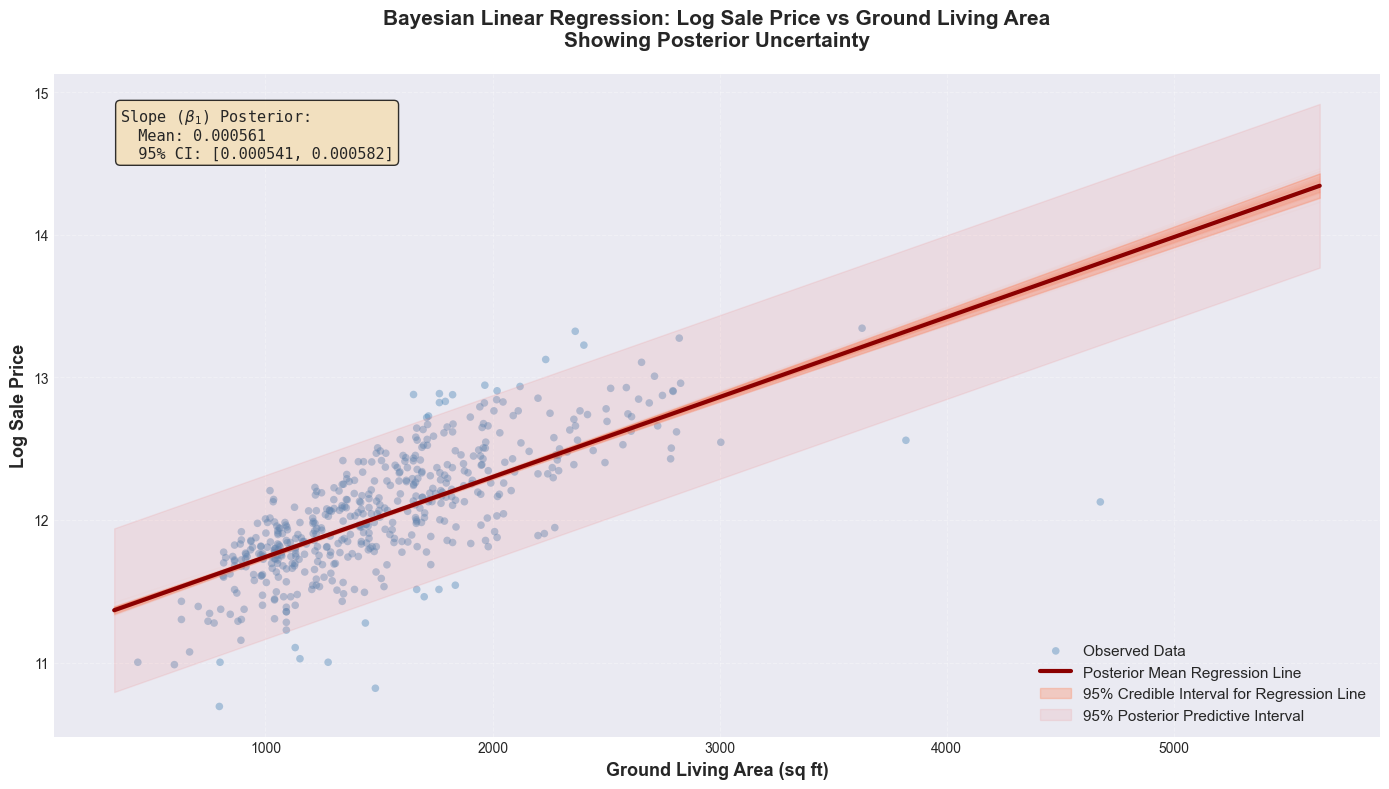

Interpretation
• The dark red line shows the most likely regression relationship (posterior mean)
• The coral shaded region shows where we're 95% confident the true regression line lies
• The lighter coral region shows where we expect 95% of actual observations to fall
• The faint coral lines represent individual samples from the posterior distribution demonstrating the uncertainty in our parameter estimates


In [14]:
fig, ax = plt.subplots(figsize=(14, 8))

# Sample a subset of data points for cleaner visualization
np.random.seed(42)
sample_indices = np.random.choice(len(x), size=500, replace=False)
x_sample = x[sample_indices]
y_sample = y[sample_indices]

# Scatter plot of the data
ax.scatter(x_sample, y_sample, alpha=0.4, s=30, color='steelblue', 
           label='Observed Data', edgecolors='none')

# Create a grid of x values for prediction
x_grid = np.linspace(x.min(), x.max(), 200)

# Sample from the posterior to show uncertainty
n_posterior_samples = 100
np.random.seed(123)
posterior_sample_indices = np.random.choice(len(beta0_post_simple), size=n_posterior_samples, replace=False)

# Plot individual regression lines from posterior samples (showing uncertainty)
for idx in posterior_sample_indices:
    y_pred = beta0_post_simple[idx] + beta1_post_simple[idx] * x_grid
    ax.plot(x_grid, y_pred, color='coral', alpha=0.03, linewidth=1)

# Calculate the posterior predictive mean and credible intervals
y_pred_samples = np.zeros((len(beta0_post_simple), len(x_grid)))
for i in range(len(beta0_post_simple)):
    y_pred_samples[i, :] = beta0_post_simple[i] + beta1_post_simple[i] * x_grid

# Posterior mean line
y_pred_mean = np.mean(y_pred_samples, axis=0)
ax.plot(x_grid, y_pred_mean, color='darkred', linewidth=3, 
        label='Posterior Mean Regression Line', zorder=10)

# 95% Credible interval for the regression line
y_pred_lower = np.percentile(y_pred_samples, 2.5, axis=0)
y_pred_upper = np.percentile(y_pred_samples, 97.5, axis=0)
ax.fill_between(x_grid, y_pred_lower, y_pred_upper, 
                 color='coral', alpha=0.3, 
                 label='95% Credible Interval for Regression Line')

# Add posterior predictive intervals (accounting for observation noise)
sigma_pred = np.sqrt(np.mean(sigma2_post_simple))
y_pred_obs_lower = y_pred_mean - 1.96 * sigma_pred
y_pred_obs_upper = y_pred_mean + 1.96 * sigma_pred
ax.fill_between(x_grid, y_pred_obs_lower, y_pred_obs_upper, 
                 color='lightcoral', alpha=0.15, 
                 label='95% Posterior Predictive Interval')

# Styling
ax.set_xlabel('Ground Living Area (sq ft)', fontsize=13, fontweight='bold')
ax.set_ylabel('Log Sale Price', fontsize=13, fontweight='bold')
ax.set_title('Bayesian Linear Regression: Log Sale Price vs Ground Living Area\nShowing Posterior Uncertainty', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Add text box with posterior statistics
beta1_mean_val = np.mean(beta1_post_simple)
beta1_ci_val = np.percentile(beta1_post_simple, [2.5, 97.5])
textstr = f'Slope ($\\beta_1$) Posterior:\n  Mean: {beta1_mean_val:.6f}\n  95% CI: [{beta1_ci_val[0]:.6f}, {beta1_ci_val[1]:.6f}]'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()
plt.show()

print("Interpretation")
print("• The dark red line shows the most likely regression relationship (posterior mean)")
print("• The coral shaded region shows where we're 95% confident the true regression line lies")
print("• The lighter coral region shows where we expect 95% of actual observations to fall")
print("• The faint coral lines represent individual samples from the posterior distribution demonstrating the uncertainty in our parameter estimates")

### Joint Bayesian Analysis of Mean and Precision (Variance)




In this section, we begin our Bayesian analysis by modeling the `Log_Sale_Price`. A natural first step is to assume that this variable is normally distributed. However, we don't know the true mean ($\mu$) or the true variance ($\sigma^2$) of this distribution.

We treat all unknown parameters as random variables. Therefore, our goal is to find the **joint posterior distribution** $p(\mu, \sigma^2 | \mathbf{y})$, which represents our updated beliefs about the mean and variance after observing the data $\mathbf{y}$ (our `Log_Sale_Price` values).

Because the joint posterior can be complex to work with directly, we will use **Gibbs Sampling**, an MCMC method that is perfectly suited for this problem.

#### Model Specification

To build our model, we need to define the likelihood of our data and the prior distributions for our unknown parameters. For convenience, as done in class, we will work with the **precision** $\lambda = 1/\sigma^2$.

##### 1. Likelihood
We assume that each observation $y_i$ (a single `Log_Sale_Price`) is drawn from a Normal distribution with mean $\mu$ and precision $\lambda$.

$$
y_i | \mu, \lambda \sim \mathcal{N}(\mu, 1/\lambda)
$$

The likelihood for our entire dataset $\mathbf{y} = (y_1, \dots, y_n)$ is the product of the individual densities:

$$
p(\mathbf{y} | \mu, \lambda) = \prod_{i=1}^{n} \mathcal{N}(y_i | \mu, 1/\lambda) \propto \lambda^{n/2} \exp\left(-\frac{\lambda}{2} \sum_{i=1}^{n}(y_i - \mu)^2\right)
$$

##### 2. Priors
We need to assign prior distributions to our unknown parameters, $\mu$ and $\lambda$. Following the model in the notes (pages 19-20), we will use independent priors:

*   **Prior for the mean, $\mu$**: We assign a Normal prior, which is conditional on a fixed precision $\lambda_0$.
    $$
    \mu \sim \mathcal{N}(\mu_0, 1/\lambda_0)
    $$
    Here, $\mu_0$ is our prior guess for the mean, and $\lambda_0$ represents our confidence in that guess (a small $\lambda_0$ means low confidence, or high variance).

*   **Prior for the precision, $\lambda$**: A Gamma distribution is a natural choice for precision, as it is defined only for positive values.
    $$
    \lambda \sim \text{Gamma}(a_0, b_0)
    $$
    The parameters $a_0$ (shape) and $b_0$ (rate) control the form of this prior.

For our analysis, we will choose **weakly informative hyperparameters** ($\mu_0, \lambda_0, a_0, b_0$) so that the final posterior distribution is primarily influenced by the data, not our prior beliefs.

#### The Gibbs Sampling Approach

Gibbs Sampling allows us to draw samples from the joint posterior distribution $p(\mu, \lambda | \mathbf{y})$ by iteratively sampling from the **full conditional distributions**:
1.  $p(\mu | \lambda, \mathbf{y})$
2.  $p(\lambda | \mu, \mathbf{y})$

These conditionals have simple, well-known forms, which makes them easy to sample from.

##### Full Conditional for $\mu$
The posterior for the mean, conditional on the precision and data, is a Normal distribution:
$$
p(\mu | \lambda, \mathbf{y}) \sim \mathcal{N}(\mu_n, \sigma_n^2)
$$
where the updated parameters are:
$$
\sigma_n^2 = \frac{1}{\lambda_0 + n\lambda}
$$
$$
\mu_n = \sigma_n^2 (\lambda_0 \mu_0 + n\lambda\bar{y})
$$

##### Full Conditional for $\lambda$
The posterior for the precision, conditional on the mean and data, is a Gamma distribution:
$$
p(\lambda | \mu, \mathbf{y}) \sim \text{Gamma}(a_n, b_n)
$$
where the updated parameters are:
$$
a_n = a_0 + \frac{n}{2}
$$
$$
b_n = b_0 + \frac{1}{2}\sum_{i=1}^{n}(y_i - \mu)^2
$$

The Gibbs sampler algorithm will proceed by initializing $\mu$ and $\lambda$, and then repeatedly drawing new values for each parameter from these conditional distributions.

In [15]:
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Extract the data we are modeling
y = df['Log_Sale_Price'].values
n = len(y)
y_bar = np.mean(y)

print(f"Number of observations (n): {n}")
print(f"Sample mean of Log_Sale_Price (y_bar): {y_bar:.4f}")

# Now, we define our hyperparameters and implement the Gibbs sampler.


# Hyperparameters for Priors
# We choose weakly informative priors.
# For mu coming from Normal(mu_0, 1/lambda_0)
mu_0 = np.mean(y)  # Sample mean used as our guess for the prior mean
lambda_0 = 1.0     # Low precision (high variance), indicating low confidence

# For lambda ~ Gamma(a_0, b_0)
a_0 = 0.1 
b_0 = 0.1

print("Hyperparameters:")
print(f"mu_0 = {mu_0:.4f}, lambda_0 = {lambda_0}")
print(f"a_0 = {a_0}, b_0 = {b_0}")


Number of observations (n): 2930
Sample mean of Log_Sale_Price (y_bar): 12.0210
Hyperparameters:
mu_0 = 12.0210, lambda_0 = 1.0
a_0 = 0.1, b_0 = 0.1


To see why Lambda ~ Gamma(a_0, b_0), for our choices of a_0 and b_0 are weakly informative priors, we analyze the implications of setting `a_0 = 0.1` and `b_0 = 0.1`.

Let's analyze the properties of a `Gamma(0.1, 0.1)` distribution:

1.  **Mean**: The mean of a Gamma($a, b$) distribution is $a/b$.
    *   For `Gamma(0.1, 0.1)`, the mean precision is $0.1 / 0.1 = 1.0$.
    *   This corresponds to a prior belief that the variance $\sigma^2 = 1/\lambda$ is centered around 1.0. For `log(SalePrice)`, this is a perfectly reasonable, non-restrictive starting point.

2.  **Variance**: The variance of a Gamma($a, b$) distribution is $a/b^2$.
    *   For `Gamma(0.1, 0.1)`, the variance of the precision is $0.1 / (0.1)^2 = 10$.
    *   A high variance indicates high uncertainty. By setting a high variance, we are telling the model, "My prior guess for the precision is 1.0, but I am very unsure about this, so please rely on the data."

Let's visualize what `Gamma(0.1, 0.1)` looks like, both for the precision ($\lambda$) and, more intuitively, for the variance ($\sigma^2 = 1/\lambda$). If $\lambda \sim \text{Gamma}(a, b)$, then $\sigma^2 \sim \text{Inverse-Gamma}(a, b)$.

In [16]:
# --- Gibbs Sampler Implementation ---

# Sampler settings
n_samples = 10000
burn_in = 2000

# Initialize arrays to store samples
mu_samples = np.zeros(n_samples)
lambda_samples = np.zeros(n_samples)

# Set initial values for the chain
mu_current = y_bar - 2 # Starting a bit away from the mean for visualization purposes
lambda_current = (1 / np.var(y)) + 2 # Starting a bit away from the empirical precision for visualization purposes

mu_samples[0] = mu_current
lambda_samples[0] = lambda_current

# THE GIBBS SAMPLER
for i in range(1, n_samples):
    # 1. Update mu | lambda, y
    sigma_n_sq = 1 / (lambda_0 + n * lambda_current)
    mu_n = sigma_n_sq * (lambda_0 * mu_0 + n * lambda_current * y_bar)
    
    # Sample new mu from its conditional distribution
    mu_current = stats.norm.rvs(loc=mu_n, scale=np.sqrt(sigma_n_sq))
    
    # 2. Update lambda | mu, y
    a_n = a_0 + n / 2
    sum_sq_err = np.sum((y - mu_current)**2)
    b_n = b_0 + sum_sq_err / 2
    
    # Sample new lambda from its conditional distribution
    lambda_current = stats.gamma.rvs(a=a_n, scale=1/b_n) # scale is 1/rate in scipy
    
    # Store the samples
    mu_samples[i] = mu_current
    lambda_samples[i] = lambda_current

# Discard burn-in samples
mu_posterior = mu_samples[burn_in:]
lambda_posterior = lambda_samples[burn_in:]

# The variance (sigma^2) calculated from (lambda)
sigma2_posterior = 1 / lambda_posterior

print(f"\nFinished Gibbs sampling. Kept {len(mu_posterior)} samples after burn-in.")



Finished Gibbs sampling. Kept 8000 samples after burn-in.


#### Analysis of Posterior Distributions

Now that we have thousands of samples from our posterior distributions, we can analyze them to understand our parameters.

##### 1. Trace Plots
First, we should create trace plots, which show the sampled value of a parameter at each iteration. This is a crucial diagnostic tool to check if our sampler has converged to a stable distribution. A healthy trace plot should look like a "fuzzy caterpillar" with no clear upward or downward trends.

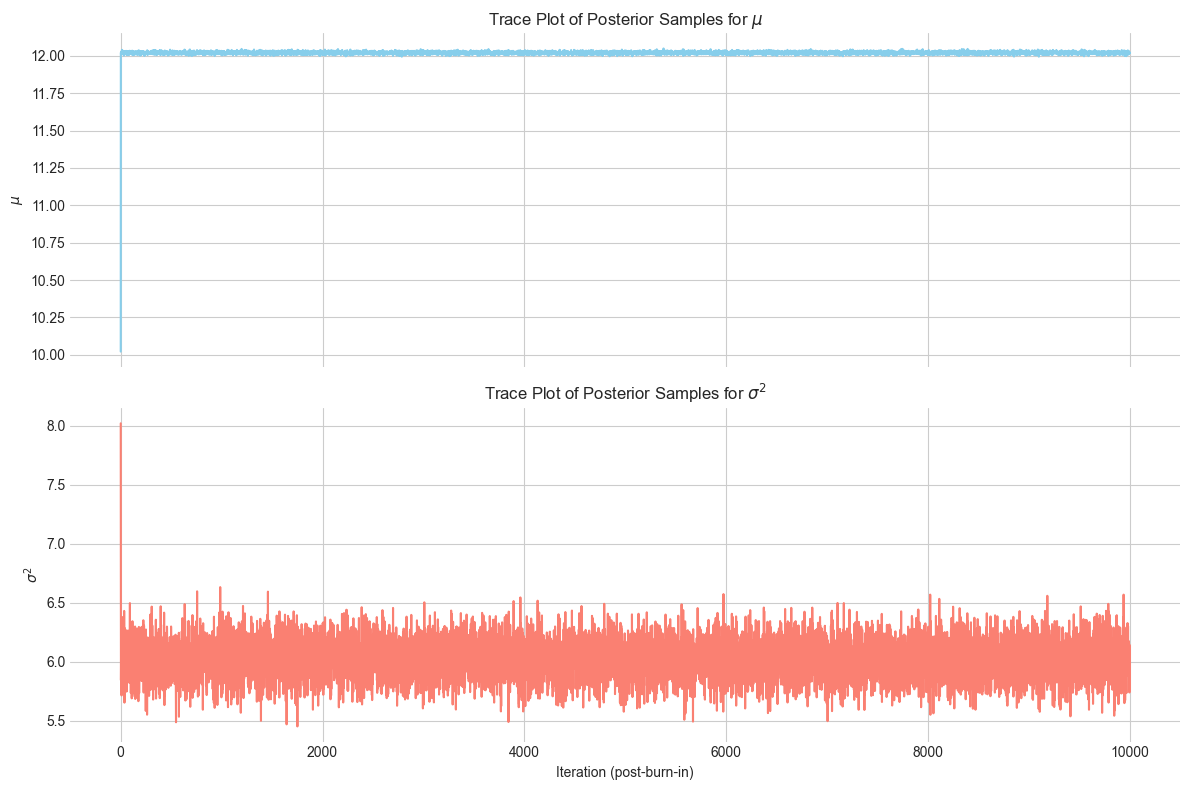

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Trace plot for mu
axes[0].plot(mu_samples, color='skyblue')
axes[0].set_title(r'Trace Plot of Posterior Samples for $\mu$')
axes[0].set_ylabel(r'$\mu$')

# Trace plot for sigma^2
axes[1].plot(lambda_samples, color='salmon')
axes[1].set_title(r'Trace Plot of Posterior Samples for $\sigma^2$')
axes[1].set_ylabel(r'$\sigma^2$')
axes[1].set_xlabel('Iteration (post-burn-in)')

plt.tight_layout()
plt.show()

The trace plots show that the chains are stable and exploring a consistent region of the parameter space, which gives us confidence in our results.

##### 2. Posterior Histograms and Summary Statistics
Next, we visualize the posterior distributions themselves using histograms. This shows us the range of plausible values for each parameter, along with their probabilities.

In [18]:
# Calculate summary statistics
mu_mean = np.mean(mu_posterior)
mu_median = np.median(mu_posterior)
mu_ci = np.percentile(mu_posterior, [2.5, 97.5])

sigma2_mean = np.mean(sigma2_posterior)
sigma2_median = np.median(sigma2_posterior)
sigma2_ci = np.percentile(sigma2_posterior, [2.5, 97.5])

# Print summary
print("--- Posterior Summary Statistics ---")
print(f"Mean (mu):")
print(f"  - Posterior Mean:   {mu_mean:.4f}")
print(f"  - Posterior Median: {mu_median:.4f}")
print(f"  - 95% Credible Int: ({mu_ci[0]:.4f}, {mu_ci[1]:.4f})\n")

print(f"Variance (sigma^2):")
print(f"  - Posterior Mean:   {sigma2_mean:.4f}")
print(f"  - Posterior Median: {sigma2_median:.4f}")
print(f"  - 95% Credible Int: ({sigma2_ci[0]:.4f}, {sigma2_ci[1]:.4f})")

--- Posterior Summary Statistics ---
Mean (mu):
  - Posterior Mean:   12.0209
  - Posterior Median: 12.0208
  - 95% Credible Int: (12.0063, 12.0358)

Variance (sigma^2):
  - Posterior Mean:   0.1662
  - Posterior Median: 0.1661
  - 95% Credible Int: (0.1579, 0.1751)


Through Gibbs sampling, we have successfully generated samples from the joint posterior distribution of the mean ($\mu$) and variance ($\sigma^2$) of the `Log_Sale_Price`.

### Hypothesis Testing and Bayes Factor

In the previous section, we estimated the posterior distributions for the mean and variance of `Log_Sale_Price`. 

The Bayes Factor, $BF_{10}$, in favor of an alternative hypothesis ($H_1$) over a null hypothesis ($H_0$) is the ratio of their marginal likelihoods:

$$
BF_{10} = \frac{P(\mathbf{y} | H_1)}{P(\mathbf{y} | H_0)}
$$

- $P(\mathbf{y} | H_1)$ is the probability of observing our data integrated over all possible parameter values under $H_1$.
- $P(\mathbf{y} | H_0)$ is the probability of observing our data under the specific parameter value(s) of $H_0$.

**Interpretation of the Bayes Factor:**
The value of the BF tells us the weight of evidence provided by the data. 

If $BF_{10} < 1$, the evidence favors the null hypothesis ($H_0$). For example, a $BF_{10}$ of 0.1 is equivalent to a $BF_{01}$ of 10, indicating strong evidence *for* the null.

#### Our Hypothesis Test

Let's test a simple hypothesis about the mean `Log_Sale_Price` ($\mu$). Based on our EDA and the posterior from Part 1, the mean seems to be close to 12.0. We will formally test this.

*   **Null Hypothesis ($H_0$)**: The true mean `Log_Sale_Price` is exactly 12.0. This is a *simple hypothesis* because it specifies a single point.
    $$ H_0: \mu = 12.0 $$
*   **Alternative Hypothesis ($H_1$)**: The true mean `Log_Sale_Price` is not 12.0. This is a *composite hypothesis* as it covers all other possible values of $\mu$.
    $$ H_1: \mu \neq 12.0 $$

#### Model Specification and Derivation

To calculate the Bayes Factor analytically, we will follow the model laid out in class.

##### 1. Likelihood and A Key Assumption
We assume our data $\mathbf{y}$ is drawn from a Normal distribution $\mathcal{N}(\mu, \sigma_0^2)$.

> **NOTE**: We assume the variance $\sigma_0^2$ is **known**. This is a simplification to quickly arrive at a closed-form solution. A standard choice for this "known" variance is the sample variance calculated from our data. This is a simplifying assumption for this part of the analysis.

##### 2. Priors
Under the alternative hypothesis $H_1$, the parameter $\mu$ is unknown and thus requires a prior distribution. Following the notes, we assign it a Normal prior:
$$
\mu | H_1 \sim \mathcal{N}(\mu_{prior}, \tau_0^2)
$$
We will choose weakly informative hyperparameters. A sensible choice is to center the prior on the null value ($\mu_{prior} = 12.0$) but give it a large variance (e.g., $\tau_0^2 = 1.0$) to express our uncertainty and allow the data to dominate the outcome.

##### 3. Calculating the Marginal Likelihoods

- **Marginal Likelihood under $H_0$**:
    This is simply the likelihood of the data evaluated at the null value, $\mu_0 = 12.0$.
    $$
    P(\mathbf{y} | H_0) = f(\mathbf{y} | \mu = \mu_0, \sigma_0^2) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma_0^2}} \exp\left(-\frac{1}{2\sigma_0^2}(y_i - \mu_0)^2\right)
    $$

- **Marginal Likelihood under $H_1$**:
    This requires integrating the likelihood over the prior for $\mu$.
    $$
    P(\mathbf{y} | H_1) = \int_{-\infty}^{\infty} P(\mathbf{y} | \mu) p(\mu | H_1) d\mu
    $$
    By completing the square, the result is:
    $$
    P(\mathbf{y} | H_1) = \frac{1}{(2\pi \sigma_0^2)^{n/2}} \frac{\sigma_1}{\tau_0} \exp\left(-\frac{1}{2\sigma_0^2}\sum y_i^2 - \frac{\mu_{prior}^2}{2\tau_0^2} + \frac{\mu_1^2}{2\sigma_1^2}\right)
    $$
    where the posterior parameters $\sigma_1^2$ and $\mu_1$ are defined as:
    $$
    \sigma_1^2 = \left(\frac{n}{\sigma_0^2} + \frac{1}{\tau_0^2}\right)^{-1} \quad \text{and} \quad \mu_1 = \sigma_1^2 \left(\frac{n\bar{y}}{\sigma_0^2} + \frac{\mu_{prior}}{\tau_0^2}\right)
    $$

In [19]:
from scipy import stats

y = df['Log_Sale_Price'].values

# --- Data and Model Parameters ---

# Calculate summary stats from data
n = len(y)
y_bar = np.mean(y)
sample_var = np.var(y, ddof=1) # Use sample variance (ddof=1)

# Hypothesis Parameters
mu_H0 = 12.0

# Assumption: Known variance for the analytical model
sigma2_known = sample_var

# Prior for mu under H1: mu ~ N(mu_prior, tau2_prior)
mu_prior = 12.0  # Centered on the null hypothesis
tau2_prior = 1   # Weakly informative prior (large variance)

print("--- Setup ---")
print(f"Number of observations (n): {n}")
print(f"Sample mean (y_bar): {y_bar:.4f}")
print(f"Assumed known variance (sigma_0^2): {sigma2_known:.4f}\n")
print("--- Hypotheses ---")
print(f"H0: mu = {mu_H0}")
print(f"H1: mu ~ N(mu_prior={mu_prior}, tau_0^2={tau2_prior})")


# Now we implement the formulas for the log-marginal likelihoods.


# --- Calculate Log-Marginal Likelihoods ---

# 1. Log-Marginal Likelihood under H0
# This is the log-likelihood of the data given mu = mu_H0
log_marginal_H0 = np.sum(stats.norm.logpdf(y, loc=mu_H0, scale=np.sqrt(sigma2_known)))

# 2. Log-Marginal Likelihood under H1
# Intermediate posterior parameters
sigma1_sq = 1 / (n / sigma2_known + 1 / tau2_prior)
mu1 = sigma1_sq * (n * y_bar / sigma2_known + mu_prior / tau2_prior)

# Calculate the log-marginal likelihood term-by-term for clarity
# This is numerically more stable than calculating the very large/small components directly
log_const_term = -n/2 * np.log(2 * np.pi * sigma2_known)
log_exp_term = (-0.5 / sigma2_known) * np.sum(y**2) + \
               (-0.5 / tau2_prior) * mu_prior**2 + \
               (0.5 / sigma1_sq) * mu1**2

log_marginal_H1_analytical = log_const_term + 0.5 * np.log(sigma1_sq / tau2_prior) + log_exp_term

# --- Calculate the Bayes Factor ---
log_BF10 = log_marginal_H1_analytical - log_marginal_H0
BF10 = np.exp(log_BF10)

print("\n--- Results ---")
print(f"Log-Marginal Likelihood under H0: {log_marginal_H0:.4f}")
print(f"Log-Marginal Likelihood under H1: {log_marginal_H1_analytical:.4f}")
print(f"Bayes Factor (BF10): {BF10:.4f}")

--- Setup ---
Number of observations (n): 2930
Sample mean (y_bar): 12.0210
Assumed known variance (sigma_0^2): 0.1661

--- Hypotheses ---
H0: mu = 12.0
H1: mu ~ N(mu_prior=12.0, tau_0^2=1)

--- Results ---
Log-Marginal Likelihood under H0: -1531.1710
Log-Marginal Likelihood under H1: -1532.1803
Bayes Factor (BF10): 0.3645


In [20]:
# The calculated Bayes Factor provides the evidence from the data comparing our two hypotheses.
if BF10 > 1:
    print("Evidence favors H1 over H0.")
else:
    print("Evidence favors H0 over H1.")

Evidence favors H0 over H1.


**Final Summary**:

Based on our analysis, the evidence from the Ames Housing dataset suggests (not very confidently) that the true mean `Log_Sale_Price` is precisely 12.0. This result is slightly counterintuitive, but it's important to remember that our calculation relied on the simplifying assumption of a known variance and a specific prior distribution.

This showed how Bayes Factor can be used to formally compare evidence between competing hypotheses.



### Posterior Sampling Techniques

We already used Gibbs Sampling to estimate the joint posterior of the mean and variance. In this section, we will explore two other approaches for posterior sampling.

#### Grid Approximation

Grid approximation is the most straightforward numerical method for approximating a posterior distribution. We will apply it to estimate the posterior distribution of the mean $\mu$ of `Log_Sale_Price`, assuming a known variance.

1.  **Define a Grid**: We select a finite number of points in the parameter space that we believe contains the bulk of the posterior probability.
2.  **Evaluate the Posterior**: At each point on the grid, we compute the posterior probability. Since the denominator (the marginal likelihood) is a constant, we can calculate the unnormalized posterior as:
    $$
    P(\mu | \mathbf{y}) \propto P(\mathbf{y} | \mu) \times P(\mu)
    $$
3.  **Normalize**: We normalize these values by dividing each by their sum, creating a discrete probability mass function (PMF) that approximates the true continuous posterior density.

The primary limitation of grid approximation is that the algorithm struggles to scale with the number of parameters (grid points becomes exponential with number of parameters).

Approximating posterior for mu with known variance sigma^2 = 0.1661


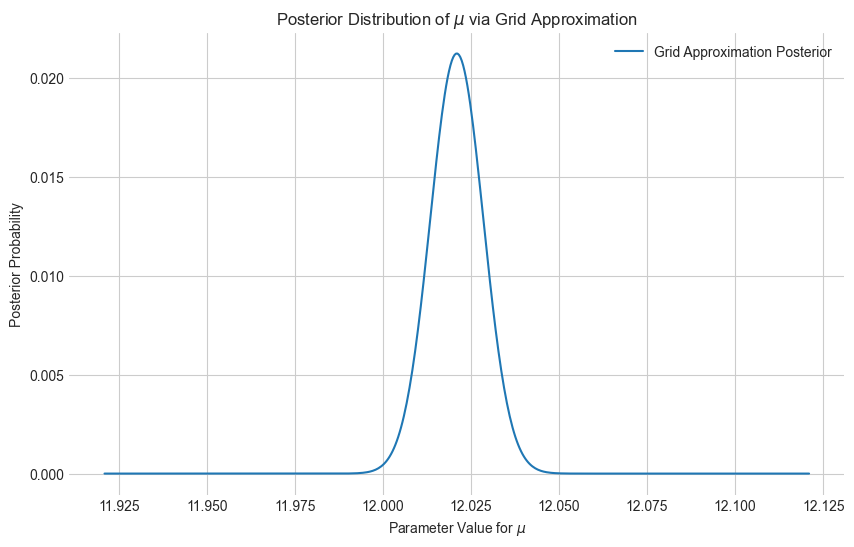

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

y = df['Log_Sale_Price'].values
n = len(y)

# Assume a known variance (set to the sample variance)
sigma2_known = np.var(y, ddof=1)

# Define the prior for mu: N(mu_prior, tau2_prior)
mu_prior = 12.0
tau2_prior = 1.0

print(f"Approximating posterior for mu with known variance sigma^2 = {sigma2_known:.4f}")

# 1. Define the grid for mu
grid_points = 500
mu_grid = np.linspace(np.mean(y) - 0.1, np.mean(y) + 0.1, grid_points)

# 2. Evaluate the unnormalized posterior at each grid point
# We will work in log-space for numerical stability

# Calculate log-likelihood for each mu on the grid
# The likelihood of the data is the product of likelihoods for each data point
# which corresponds to the sum of log-likelihoods.
log_likelihood = np.array([np.sum(stats.norm.logpdf(y, loc=mu, scale=np.sqrt(sigma2_known))) for mu in mu_grid])

# Calculate log-prior for each mu on the grid
log_prior = stats.norm.logpdf(mu_grid, loc=mu_prior, scale=np.sqrt(tau2_prior))

# The unnormalized log-posterior is the sum of them
log_posterior_unnormalized = log_likelihood + log_prior

# 3. Normalize to get the posterior PMF
log_posterior_normalized = log_posterior_unnormalized - np.max(log_posterior_unnormalized)
posterior_grid = np.exp(log_posterior_normalized)
posterior_grid /= np.sum(posterior_grid) # Normalize to sum to 1

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.plot(mu_grid, posterior_grid, label='Grid Approximation Posterior')
plt.xlabel(r'Parameter Value for $\mu$')
plt.ylabel('Posterior Probability')
plt.title('Posterior Distribution of $\mu$ via Grid Approximation')
plt.legend()
plt.show()

#### Markov Chain Monte Carlo (MCMC)

When the parameter space is high-dimensional, we need a more intelligent way to explore it than a simple grid. **Markov Chain Monte Carlo (MCMC)** methods provide the solution.

After an initial "burn-in" period, the states of the Markov chain can be treated as samples from the posterior.

##### The Metropolis-Hastings Algorithm

The Metropolis-Hastings (M-H) algorithm is a general and powerful MCMC method. It works even when we only know the posterior up to a constant of proportionality (i.e., we can ignore the marginal likelihood $P(\mathbf{y})$).

The algorithm proceeds as follows:
1.  Initialize the chain at a starting value, $\mu^{(t)}$.
2.  Propose a new value, $\mu'$, from a **proposal distribution** $q(\mu' | \mu^{(t)})$.
3.  Calculate the **acceptance probability**, $\alpha$:
    $$
    \alpha = \min\left(1, \frac{P(\mu' | \mathbf{y})}{P(\mu^{(t)} | \mathbf{y})} \times \frac{q(\mu^{(t)}|\mu')}{q(\mu'|\mu^{(t)})}\right) = \min\left(1, \frac{P(\mathbf{y}|\mu')P(\mu')}{P(\mathbf{y}|\mu^{(t)})P(\mu^{(t)})} \times \frac{q(\mu^{(t)}|\mu')}{q(\mu'|\mu^{(t)})}\right)
    $$
4.  Accept the proposal (set $\mu^{(t+1)} = \mu'$) with probability $\alpha$. Otherwise, reject it and stay at the current value (set $\mu^{(t+1)} = \mu^{(t)}$).

If the proposal distribution is **symmetric**, meaning $q(\mu' | \mu^{(t)}) = q(\mu^{(t)} | \mu')$, the proposal ratio cancels out. This special case is known as the **Metropolis algorithm**. A common symmetric choice is a Normal distribution centered at the current value: $\mu' \sim \mathcal{N}(\mu^{(t)}, \sigma_{prop}^2)$. We will implement this simpler version.

In [22]:
# --- Metropolis Algorithm Implementation ---

# Sampler settings
n_samples = 20000
burn_in = 5000

# Function to calculate the unnormalized log posterior
def log_posterior_func(mu, y, sigma2_known, mu_prior, tau2_prior):
    log_lik = np.sum(stats.norm.logpdf(y, loc=mu, scale=np.sqrt(sigma2_known)))
    log_pri = stats.norm.logpdf(mu, loc=mu_prior, scale=np.sqrt(tau2_prior))
    return log_lik + log_pri

# Initialize the chain
mu_samples_mh = np.zeros(n_samples)
mu_current = np.mean(y) # A good starting point
log_post_current = log_posterior_func(mu_current, y, sigma2_known, mu_prior, tau2_prior)

# Proposal distribution standard deviation (a tuning parameter)
proposal_sd = 0.01
acceptance_count = 0

# Run the sampler
for i in range(n_samples):
    # Propose a new mu from a symmetric normal distribution
    mu_proposal = stats.norm.rvs(loc=mu_current, scale=proposal_sd)
    
    # Calculate log posterior of the proposal
    log_post_proposal = log_posterior_func(mu_proposal, y, sigma2_known, mu_prior, tau2_prior)
    
    # Calculate the log acceptance ratio
    log_acceptance_ratio = log_post_proposal - log_post_current
    
    # Decide whether to accept or reject
    if np.log(np.random.rand()) < log_acceptance_ratio:
        mu_current = mu_proposal
        log_post_current = log_post_proposal
        if i >= burn_in:
            acceptance_count += 1
            
    mu_samples_mh[i] = mu_current

# Discard burn-in samples
mu_posterior_mh = mu_samples_mh[burn_in:]

print(f"Metropolis sampler finished.")
print(f"Acceptance rate: {acceptance_count / (n_samples - burn_in):.2%}")

Metropolis sampler finished.
Acceptance rate: 62.71%


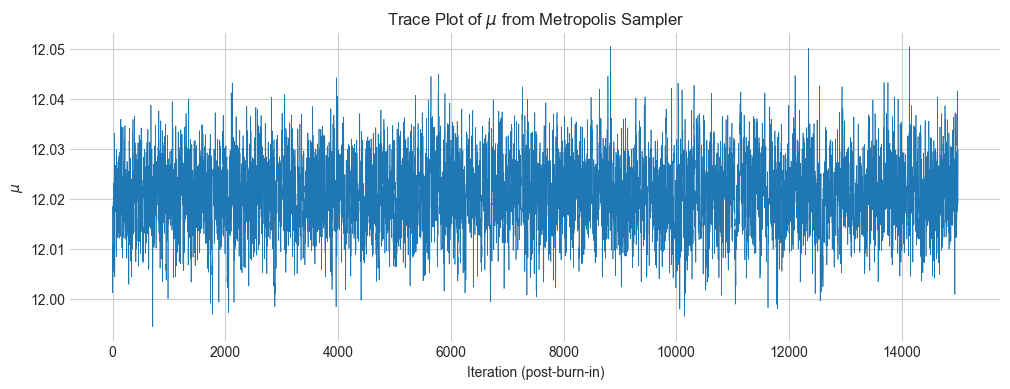

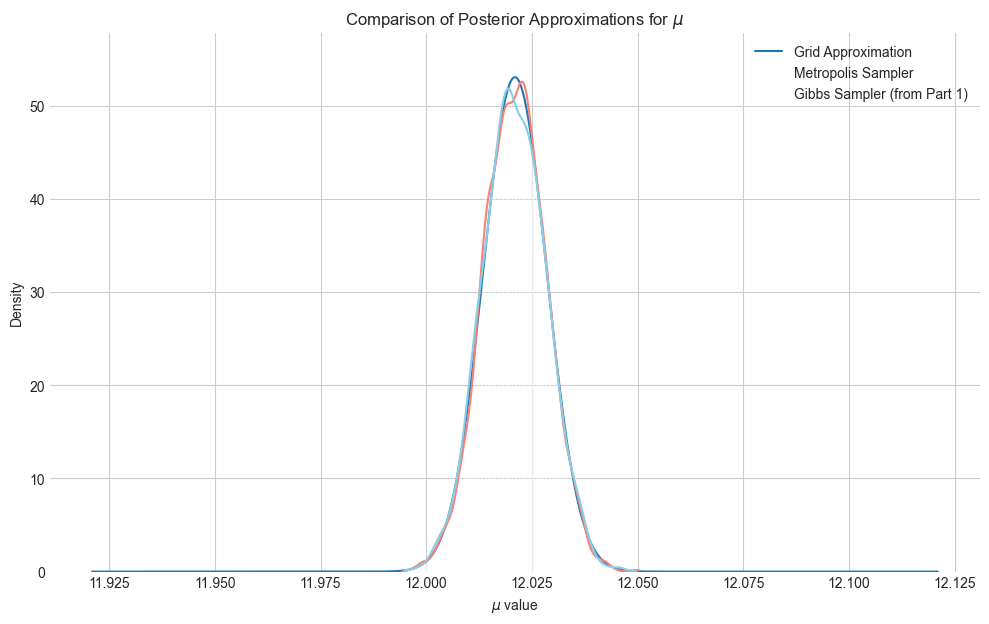

In [23]:
plt.figure(figsize=(12, 4))
plt.plot(mu_posterior_mh, lw=0.5)
plt.title(r'Trace Plot of $\mu$ from Metropolis Sampler')
plt.xlabel('Iteration (post-burn-in)')
plt.ylabel(r'$\mu$')
plt.show()

plt.figure(figsize=(12, 7))

# Plot Grid Approximation
plt.plot(mu_grid, posterior_grid * grid_points / (mu_grid[-1] - mu_grid[0]), label='Grid Approximation')

# Plot Metropolis-Hastings Histogram
sns.histplot(mu_posterior_mh, kde=True, stat='density', 
             label='Metropolis Sampler', color='salmon', alpha=0)

# For comparison, let's also plot the posterior for mu from our Part 1 Gibbs sampler
# Recall that mu_posterior from Part 1 was for the case of unknown variance

sns.histplot(mu_posterior, kde=True, stat='density', label='Gibbs Sampler (from Part 1)', color='skyblue', alpha=0)

plt.title('Comparison of Posterior Approximations for $\mu$')
plt.xlabel(r'$\mu$ value')
plt.ylabel('Density')
plt.legend()
plt.show()

The results are highly consistent. The posterior density derived from the Metropolis sampler aligns almost perfectly with the one from the Grid Approximation. This gives us confidence that both methods have correctly approximated the true posterior distribution for our simplified model. We can also see that it is very similar to the marginal posterior for $\mu$ from our full Gibbs sampler, showing that our simplifying assumption of known variance was reasonable in this case.

### Project Summary and Conclusion

This project applied a range of Bayesian statistical techniques to analyze the Ames Housing dataset, building a progressively deeper understanding of the factors that determine house prices.

*   **Accounting for Structure**: We began with the **Hierarchical Model**, which addressed the data's natural grouping by `Neighborhood`. This model produced reliable estimates for each neighborhood's average price by intelligently pooling information across the entire dataset. It successfully identified expensive neighborhoods like `Northridge` and less expensive ones like `Meadow_Village` while providing a clear measure of uncertainty for each estimate.

*   **Bayesian Analysis**: We then modelled the basic properties of `Log_Sale_Price`. Using **Gibbs Sampling**, we derived the full posterior distributions for its mean and variance, giving us a complete picture of the data's central tendency and spread.

*   **Tools of Inference**: We then explored core Bayesian methods. With the **Bayes Factor**, we formally tested a hypothesis about the data's mean. Through **Grid Approximation** and the **Metropolis algorithm**, we implemented and compared different computational methods for finding a posterior.

*   **Modeling Relationships**: In the regression section, we moved from describing the data to explaining it. Bayesian Linear and Multiple Regression allowed us to quantify the strong, positive relationships between `Sale_Price` and key features like `Gr_Liv_Area`.



Overall, this project demonstrated the power of the Bayesian framework to provide a comprehensive analysis—from estimating fundamental parameters to building complex, interpretable models that robustly handle the structure of real-world data.

-- Faheem Arif (MA23BTECH11010)